# Flight Delay Analysis and Prediction 

### Problem Definition (Business Case)

As the air travels have a significant role in economy of agencies and airports, it is necessary for them to increase quality of their services.
One of the important modern life challenges of airports and airline agencies is flight delay. In addition, delay in flight makes passengers concerned and this matter causes extra expenses for the agency and the airport itself, some of the obstacle airlines go through are

* They disrupt the purpose of air travel — rapid, affordable and safe — and make the passengers distrust airlines.
* Increased travel time results and increased expenses on food and lodging.
* More travel time results in more fuel consumption.
* Airlines will be required to pay for the bulk of flight delay remediation efforts.
* Airlines suffer loss of reputation and bad business relations, and many more..

The impact of flight delay can be a risk representing financial losses,Hence it is crucial for airlines to predict the flight delays prior, which allows them to manage airtraffic, be prepared for unavoidable delays and to schedule other flights accordingly.


### ML Problem Statement

This problem can be addressed with the help of Machine Learning/Deep Learning which produces relatively more accurate outcomes. Various data provided by the Airlines such as Flight trip details, Weatherstation Data, Hourly Weather data and Precipitation data and Quantity of these data can be benificial for the creation of a Machine Learning Model and optimisation of ML Model.

A better ML Model can predict the outcomes accurately to inform about the probability of the delay that can be Experianced in the Airlines and rescheduling of other flights and to inform the passengers about the occourance of the delay to manage the Time

This can benefit both airlines and passengers, better prediction results in reduced inventory and operation costs of airlines and helps with economy,
reduced costs mean the travelling expences will be reduced for passengers by maintaining the same profit margin for the airlines.

### Available Data

In the given problem, we are provided with the data consisting 

* flight trip details as   -- Train.csv & Test.csv
* Hourly weather data as   -- hourly.txt
* Precipitation Data as    -- hpd.txt
* weatherstation data as   -- AllStationsData_PHD.txt

we can link hourly, hpd and AllStationsData_PHD using WeatherStationID,
and AllStationsData_PHD with Train and Test data by Airport ID with Origin and Destination ID.

## Importing Libraries 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1200px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [3]:
import pandas as pd
import numpy as np
import datetime
import re

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Loading the Datasets

In [4]:
trn = pd.read_csv("Train.csv")
tst = pd.read_csv("Test.csv")
weatherstation = pd.read_csv("AllStationsData_PHD.txt",sep='|')

In [5]:
h0401 = pd.read_csv("200401hourly.txt")
h0403 = pd.read_csv("200403hourly.txt")
h0405 = pd.read_csv("200405hourly.txt")
h0407 = pd.read_csv("200407hourly.txt")
h0409 = pd.read_csv("200409hourly.txt")
h0411 = pd.read_csv("200411hourly.txt")

h0503 = pd.read_csv("200503hourly.txt")
h0507 = pd.read_csv("200507hourly.txt")
h0509 = pd.read_csv("200509hourly.txt")
h0511 = pd.read_csv("200511hourly.txt")

In [6]:
p0401 = pd.read_csv("200401hpd.txt")
p0403 = pd.read_csv("200403hpd.txt")
p0405 = pd.read_csv("200405hpd.txt")
p0407 = pd.read_csv("200407hpd.txt")
p0409 = pd.read_csv("200409hpd.txt")
p0411 = pd.read_csv("200411hpd.txt")

p0503 = pd.read_csv("200503hpd.txt")
p0507 = pd.read_csv("200507hpd.txt")
p0509 = pd.read_csv("200509hpd.txt")
p0511 = pd.read_csv("200511hpd.txt")

## Merging the datasets to a single Dataframe Time conversion

The Train data set has 12 columns where as Test data has 11 columns, the extra column in train data is ActualArrivaTimeStamp,
we can seperate that column from Train dataset and merge Train and Test dataset to a single Dataframe.

We can't do any operations based on local time on the dataset since all the locations will be in different Timezones, so we should first convert all the local timings to UTC (GMT).

Here we convert each local time to UTC by subtracting the Timezone provided based on the Airport ID
* LocalTime - Timezone = UTC Time 

In [7]:
## merging train and test

trn.shape, tst.shape

((7861, 12), (6566, 11))

In [8]:
trn.head(2)

,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,Distance,ActualArrivalTimeStamp
0,BOS_CLE_29089,2004,9,20,1,1000,1154,114,BOS,CLE,563,20/09/04 11:54
1,CLE_ATL_44346,2004,11,19,5,1440,1634,114,CLE,ATL,554,19/11/04 18:55


In [9]:
tst.head(2)

,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,Distance
0,DEN_XNA_62349,2005,9,12,1,1516,1756,100,DEN,XNA,616
1,RIC_EWR_87213,2005,11,14,1,1300,1415,75,RIC,EWR,278


In [10]:
print("train:",trn.Year.value_counts(), "\n\ntest:",tst.Year.value_counts())

train: 2004    7861
Name: Year, dtype: int64 

test: 2005    6566
Name: Year, dtype: int64


In [11]:
## Extracting the Actual arrival timestamp and Destination from train dataset.

actarr = pd.DataFrame(trn["ActualArrivalTimeStamp"], columns =['ActualArrivalTimeStamp'])
actarr["Destination"] = trn.Destination
trn.drop(['ActualArrivalTimeStamp'],axis = 1, inplace = True)

In [12]:
actarr.shape,actarr.head(10)

((7861, 2),
   ActualArrivalTimeStamp Destination
 0         20/09/04 11:54         CLE
 1         19/11/04 18:55         ATL
 2         04/05/04 19:02         LAS
 3         06/07/04 15:33         TPA
 4         23/09/04 09:46         ORD
 5         26/09/04 18:32         GRR
 6         05/05/04 15:17         STL
 7         15/09/04 07:58         SFO
 8         28/05/04 18:39         DFW
 9         11/09/04 12:23         PIT)

In [13]:
data = [trn,tst]
df = pd.concat(data)
df = df.reset_index(drop=True)

In [14]:
df[7859:7863]

,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,Distance
7859,SLC_GEG_25787,2004,1,4,7,1130,1214,104,SLC,GEG,546
7860,FLL_CLE_41967,2004,11,6,6,1325,1613,168,FLL,CLE,1062
7861,DEN_XNA_62349,2005,9,12,1,1516,1756,100,DEN,XNA,616
7862,RIC_EWR_87213,2005,11,14,1,1300,1415,75,RIC,EWR,278


In [15]:
df.shape

(14427, 11)

In [16]:
##                                           *** Weatherstation Data ***
## Removing invalid Timezones in weatherstation data.

weatherstation.head(2)

,WeatherStationID,AirportID,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,TimeZone
0,3011,TEX,0,0,0,37.57,-107.55,+7
1,3012,SKX,0,0,0,36.28,-105.40,+7


In [17]:
weatherstation.TimeZone.unique()

array(['+7', '+6', '+8', '+5', '+4', '+9', '+10', 'Yukon Standard', '-10',
       'Bering Standard', 'Alaska-Hawaii', 'Eastern Standard'],
      dtype=object)

In [18]:
weatherstation.rmtimezone = ['-10', 'Yukon Standard','Bering Standard','Alaska-Hawaii','Eastern Standard']
weatherstation = weatherstation[~weatherstation.TimeZone.isin(weatherstation.rmtimezone)]
weatherstation = weatherstation.reset_index(drop=True)
weatherstation.TimeZone.unique()

array(['+7', '+6', '+8', '+5', '+4', '+9', '+10'], dtype=object)

In [19]:
weatherstation.TimeZone = pd.to_numeric(weatherstation.TimeZone)
weatherstation.TimeZone =  pd.TimedeltaIndex(weatherstation.TimeZone, unit='h')
weatherstation.head()

,WeatherStationID,AirportID,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,TimeZone
0,3011,TEX,0,0,0,37.57,-107.55,0 days 07:00:00
1,3012,SKX,0,0,0,36.28,-105.40,0 days 07:00:00
2,3013,LAA,3683,3703,3675,38.04,-102.41,0 days 07:00:00
3,3014,4SL,0,6909,0,35.47,-107.14,0 days 07:00:00
4,3016,RIL,5503,5544,5506,39.32,-107.44,0 days 07:00:00


In [20]:
##   merging hourly weather data of every month to a single Dataframe.


hour4 = [h0401,h0403,h0405,h0407,h0409,h0411]
hour4 = pd.concat(hour4)

hour5 = [h0503,h0507,h0509,h0511]
hour5 = pd.concat(hour5)

In [21]:
hdf = [hour4,hour5]
hour = pd.concat(hdf)
hour = hour.reset_index(drop=True)

In [22]:
hour.shape

(11516906, 12)

In [23]:
hour.head(2)

,WeatherStationID,YearMonthDay,Time,SkyConditions,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,WindSpeed,WindDirection,WindGustValue,StationPressure
0,3034,20040101,10,OVC095,10SM,30.0,7.0,38.0,0.0,000,0.0,30.10
1,3035,20040101,10,SCT110,10SM,43.0,18.0,37.0,0.0,000,0.0,30.07


In [24]:
hour.Time = hour.Time.astype(str).str.zfill(4)
hour["Time"] = pd.to_datetime(hour.YearMonthDay.astype(str) + ' ' +hour.Time.astype(str))
hour.head(2)

,WeatherStationID,YearMonthDay,Time,SkyConditions,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,WindSpeed,WindDirection,WindGustValue,StationPressure
0,3034,20040101,2004-01-01 00:10:00,OVC095,10SM,30.0,7.0,38.0,0.0,000,0.0,30.10
1,3035,20040101,2004-01-01 00:10:00,SCT110,10SM,43.0,18.0,37.0,0.0,000,0.0,30.07


In [25]:
hour = hour.reset_index().merge(weatherstation, how='left',left_on = "WeatherStationID",right_on="WeatherStationID").set_index('index')
hour = hour.sort_index(axis = 0)

In [26]:
## converting Localtime to UTC time based on weatherstation Timezone

hour.Time = hour.Time - hour.TimeZone
hour['visibility'] = hour.Visibility.str.extract('([-]?[\d.]*)', expand=False).str.strip()

In [27]:
hour.drop(['YearMonthDay', 'AirportID', 'GroundHeight', 'StationHeight',
           'BarometerHeight', 'Latitude', 'Longitude', 'TimeZone','Visibility'],axis = 1,inplace = True)

In [28]:
hour.rename(columns = {'WeatherStationID':'ws_id','DewPointTemp':'DPT','RelativeHumidityPercent':'RHP','StationPressure':'preassure'}, inplace = True)

In [29]:
hour.head()

,ws_id,Time,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility
index,,,,,,,,,,,
0,3034,2003-12-31 17:10:00,OVC095,30.0,7.0,38.0,0.0,000,0.0,30.10,10
1,3035,2003-12-31 17:10:00,SCT110,43.0,18.0,37.0,0.0,000,0.0,30.07,10
2,3039,2003-12-31 17:10:00,OVC002,14.0,12.0,92.0,0.0,000,0.0,30.01,0.25
3,3040,2003-12-31 17:10:00,CLR,30.0,21.0,69.0,9.0,250,0.0,29.82,10
4,4128,2003-12-31 16:10:00,BKN001 BKN010 OVC024,NaN,NaN,NaN,0.0,000,0.0,29.80,4


__Rounding Off the UTC Time

We wont get enough data if we keep the Time in their original state, Theres not many exact match for the flight departure and arrival timings with the hourly or precipitation data, so we can round off the Time values to the hour and neglect the minute values.

Neglecting the minute values doesnot make much of a difference since weather is less likely to be changed in a matte of minutes.

In [30]:
## roundingoff the houry time Hour

hour['Time_ro'] = hour.Time
hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11516906 entries, 0 to 11516905
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ws_id          int64         
 1   Time           datetime64[ns]
 2   SkyConditions  object        
 3   DBT            float64       
 4   DPT            float64       
 5   RHP            float64       
 6   WindSpeed      object        
 7   WindDirection  object        
 8   WindGustValue  float64       
 9   preassure      float64       
 10  visibility     object        
 11  Time_ro        datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(1), object(4)
memory usage: 1.1+ GB


In [31]:
hour["Time_ro"] = np.array(hour.Time_ro, dtype='datetime64[h]')
hour.head()

,ws_id,Time,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,Time_ro
index,,,,,,,,,,,,
0,3034,2003-12-31 17:10:00,OVC095,30.0,7.0,38.0,0.0,000,0.0,30.10,10,2003-12-31 17:00:00
1,3035,2003-12-31 17:10:00,SCT110,43.0,18.0,37.0,0.0,000,0.0,30.07,10,2003-12-31 17:00:00
2,3039,2003-12-31 17:10:00,OVC002,14.0,12.0,92.0,0.0,000,0.0,30.01,0.25,2003-12-31 17:00:00
3,3040,2003-12-31 17:10:00,CLR,30.0,21.0,69.0,9.0,250,0.0,29.82,10,2003-12-31 17:00:00
4,4128,2003-12-31 16:10:00,BKN001 BKN010 OVC024,NaN,NaN,NaN,0.0,000,0.0,29.80,4,2003-12-31 16:00:00


In [32]:
hour = hour.drop_duplicates(
  subset = ['ws_id', 'Time_ro'],
  keep = 'last').reset_index(drop = True)

In [33]:
hour.head()

,ws_id,Time,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,Time_ro
0,94061,2004-01-01 04:01:00,NaN,25.0,18.0,75.0,1.0,230,0.0,29.94,NaN,2004-01-01 04:00:00
1,53890,2004-01-01 05:21:00,CLR,48.0,25.0,41.0,0.0,000,0.0,30.44,10,2004-01-01 05:00:00
2,26535,2004-01-01 01:35:00,CLR,-13.0,-18.0,78.0,0.0,000,0.0,30.32,10,2004-01-01 01:00:00
3,3705,2004-01-01 05:40:00,CLR,55.0,25.0,31.0,0.0,000,0.0,30.45,10,2004-01-01 05:00:00
4,3706,2004-01-01 05:40:00,CLR,46.0,28.0,50.0,0.0,000,0.0,30.42,10,2004-01-01 05:00:00


In [34]:
## merging hourly precipitation data to a single Dataframe.

ppt4 = [p0401,p0403,p0405,p0407,p0409,p0411]
ppt4 = pd.concat(ppt4)

ppt5 = [p0503,p0507,p0509,p0511]
ppt5 = pd.concat(ppt5)

In [35]:
pdf = [ppt4,ppt5]
ppt = pd.concat(pdf)
ppt = ppt.reset_index(drop=True)

In [36]:
ppt.shape

(12107407, 4)

In [37]:
ppt.tail(4)

,WeatherStationID,YearMonthDay,Time,HourlyPrecip
12107403,40504,20051130,2358,0.0
12107404,40309,20051130,2359,0.0
12107405,93167,20051130,2359,0.0
12107406,94950,20051130,2359,0.0


In [38]:
ppt.Time = ppt.Time.astype(str).str.zfill(4)
ppt["Time"] = pd.to_datetime(ppt.YearMonthDay.astype(str) + ' ' +ppt.Time.astype(str))
ppt.head(2)

,WeatherStationID,YearMonthDay,Time,HourlyPrecip
0,3034,20040101,2004-01-01 00:10:00,0.0
1,3035,20040101,2004-01-01 00:10:00,0.0


In [39]:
ppt = ppt.reset_index().merge(weatherstation, how='left',left_on = "WeatherStationID",right_on="WeatherStationID").set_index('index')
ppt = ppt.sort_index(axis = 0)

In [40]:
## converting Localtime to UTC time based on weatherstation Timezone

ppt.Time = ppt.Time - ppt.TimeZone

In [41]:
ppt.head(2)

,WeatherStationID,YearMonthDay,Time,HourlyPrecip,AirportID,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,TimeZone
index,,,,,,,,,,,
0,3034,20040101,2003-12-31 17:10:00,0.0,AEG,0.0,0.0,0.0,35.09,-106.48,0 days 07:00:00
1,3035,20040101,2003-12-31 17:10:00,0.0,ATS,0.0,0.0,0.0,32.51,-104.28,0 days 07:00:00


In [42]:
ppt.drop(['YearMonthDay', 'AirportID', 'GroundHeight', 'StationHeight',
           'BarometerHeight', 'Latitude', 'Longitude', 'TimeZone'],axis = 1,inplace = True)

In [43]:
ppt.tail(2)

,WeatherStationID,Time,HourlyPrecip
index,,,
12107405,93167,2005-11-30 16:59:00,0.0
12107406,94950,2005-11-30 17:59:00,0.0


In [44]:
## roundingoff the houry time Hour

ppt['Time_roundoff'] = ppt.Time

In [45]:
ppt["Time_roundoff"] = np.array(ppt.Time_roundoff, dtype='datetime64[h]')

In [46]:
ppt = ppt.drop_duplicates(
  subset = ['WeatherStationID', 'Time_roundoff'],
  keep = 'last').reset_index(drop = True)

ppt.head()

,WeatherStationID,Time,HourlyPrecip,Time_roundoff
0,53943,2003-12-31 18:20:00,0.0,2003-12-31 18:00:00
1,3701,2003-12-31 19:39:00,0.0,2003-12-31 19:00:00
2,3717,2003-12-31 19:39:00,0.0,2003-12-31 19:00:00
3,53801,2003-12-31 19:39:00,0.0,2003-12-31 19:00:00
4,3702,2003-12-31 19:40:00,0.0,2003-12-31 19:00:00


## Merging ppt with hour data based on Weatherstation ID and Roundoff Time

In [47]:
hour = hour.drop_duplicates(
  subset = ['ws_id', 'Time_ro'],
  keep = 'last').reset_index(drop = True)

In [48]:
hour = hour.reset_index().merge(ppt, how='left', left_on = ["ws_id","Time_ro"] ,right_on = ["WeatherStationID","Time_roundoff"]).set_index('index')
hour = hour.sort_index(axis = 0)

In [49]:
hour.head()

,ws_id,Time_x,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,Time_ro,WeatherStationID,Time_y,HourlyPrecip,Time_roundoff
index,,,,,,,,,,,,,,,,
0,94061,2004-01-01 04:01:00,NaN,25.0,18.0,75.0,1.0,230,0.0,29.94,NaN,2004-01-01 04:00:00,94061.0,2004-01-01 04:01:00,0.0,2004-01-01 04:00:00
1,53890,2004-01-01 05:21:00,CLR,48.0,25.0,41.0,0.0,000,0.0,30.44,10,2004-01-01 05:00:00,53890.0,2004-01-01 05:21:00,0.0,2004-01-01 05:00:00
2,26535,2004-01-01 01:35:00,CLR,-13.0,-18.0,78.0,0.0,000,0.0,30.32,10,2004-01-01 01:00:00,26535.0,2004-01-01 01:35:00,0.0,2004-01-01 01:00:00
3,3705,2004-01-01 05:40:00,CLR,55.0,25.0,31.0,0.0,000,0.0,30.45,10,2004-01-01 05:00:00,3705.0,2004-01-01 05:40:00,0.0,2004-01-01 05:00:00
4,3706,2004-01-01 05:40:00,CLR,46.0,28.0,50.0,0.0,000,0.0,30.42,10,2004-01-01 05:00:00,3706.0,2004-01-01 05:40:00,0.0,2004-01-01 05:00:00


In [50]:
hour.drop(['Time_y','WeatherStationID','Time_roundoff'],axis = 1,inplace = True)
hour.rename(columns = {'Time_x':'time'},inplace = True)

In [51]:
hour = hour.drop_duplicates(
  subset = ['ws_id', 'Time_ro'],
  keep = 'last').reset_index(drop = True)

In [52]:
hour.shape

(9039250, 13)

In [53]:
hour.head()

,ws_id,time,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,Time_ro,HourlyPrecip
0,94061,2004-01-01 04:01:00,NaN,25.0,18.0,75.0,1.0,230,0.0,29.94,NaN,2004-01-01 04:00:00,0.0
1,53890,2004-01-01 05:21:00,CLR,48.0,25.0,41.0,0.0,000,0.0,30.44,10,2004-01-01 05:00:00,0.0
2,26535,2004-01-01 01:35:00,CLR,-13.0,-18.0,78.0,0.0,000,0.0,30.32,10,2004-01-01 01:00:00,0.0
3,3705,2004-01-01 05:40:00,CLR,55.0,25.0,31.0,0.0,000,0.0,30.45,10,2004-01-01 05:00:00,0.0
4,3706,2004-01-01 05:40:00,CLR,46.0,28.0,50.0,0.0,000,0.0,30.42,10,2004-01-01 05:00:00,0.0


## Converting  Local time to UTC time

In [54]:
df.ScheduledDepTime = df.ScheduledDepTime.astype(str).str.zfill(4)
df.ScheduledArrTime = df.ScheduledArrTime.astype(str).str.zfill(4)
df.DayofMonth = df.DayofMonth.astype(str).str.zfill(2)
df.Month = df.Month.astype(str).str.zfill(2)
df.Year = df.Year.astype(str).str.zfill(4)

In [55]:
df["date"] = df.Year.astype(str)+df.Month.astype(str)+df.DayofMonth.astype(str)
df["ScheduledDepTime"] = pd.to_datetime(df.date.astype(str) + ' ' +df.ScheduledDepTime.astype(str))
df["ScheduledArrTime"] = pd.to_datetime(df.date.astype(str) + ' ' +df.ScheduledArrTime.astype(str))
df = df.drop(['Month', 'DayofMonth','date'],axis = 1)

In [56]:
df.head()

,FlightNumber,Year,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,Distance
0,BOS_CLE_29089,2004,1,2004-09-20 10:00:00,2004-09-20 11:54:00,114,BOS,CLE,563
1,CLE_ATL_44346,2004,5,2004-11-19 14:40:00,2004-11-19 16:34:00,114,CLE,ATL,554
2,SNA_LAS_44378,2004,2,2004-05-04 18:00:00,2004-05-04 19:02:00,62,SNA,LAS,226
3,CLT_TPA_51502,2004,2,2004-07-06 14:00:00,2004-07-06 15:33:00,93,CLT,TPA,508
4,MSP_ORD_44884,2004,4,2004-09-23 08:30:00,2004-09-23 09:46:00,76,MSP,ORD,334


In [57]:
## ScheduledDepTime to ------> UTC dep time

a=0
for i in df.Origin:
    b=0
    for j in weatherstation.AirportID:
        if (i==j): 
            df.ScheduledDepTime[a] = df.ScheduledDepTime[a] - weatherstation.TimeZone[b]
        b=b+1               
    a=a+1
df.rename(columns = {'ScheduledDepTime':'utc_dep'}, inplace = True)

In [58]:
## ScheduledArrTime to -----> UTC arrival time

a=0
for i in df.Destination:
    b=0
    for j in weatherstation.AirportID:
        if (i==j): 
            df.ScheduledArrTime[a] = df.ScheduledArrTime[a] - weatherstation.TimeZone[b]
        b=b+1               
    a=a+1
df.rename(columns = {'ScheduledArrTime':'utc_arr'}, inplace = True)


In [59]:
df.utc_arr = pd.to_datetime(df.utc_arr)

In [60]:
df.head()

,FlightNumber,Year,DayOfWeek,utc_dep,utc_arr,ScheduledTravelTime,Origin,Destination,Distance
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334


In [61]:
df["O_ws_id"] = 0
df["D_ws_id"] = 0

In [62]:
## Importing Origin weatherstation id from weatherstation Dataframe

a=0
for i in df.Origin:
    b=0
    for j in weatherstation.AirportID:
        if (i==j): 
            df["O_ws_id"][a] = weatherstation.WeatherStationID[b]
        b=b+1               
    a=a+1

In [63]:
## Importing Destination weatherstation id from weatherstation Dataframe

a=0
for i in df.Destination:
    b=0
    for j in weatherstation.AirportID:
        if (i==j): 
            df["D_ws_id"][a] = weatherstation.WeatherStationID[b]
        b=b+1               
    a=a+1

In [64]:
df.head()

,FlightNumber,Year,DayOfWeek,utc_dep,utc_arr,ScheduledTravelTime,Origin,Destination,Distance,O_ws_id,D_ws_id
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846


##  Merging weatherstation Dataframe with train-test Dataframe

In [65]:
df = df.reset_index().merge(weatherstation, how='left', left_on = "O_ws_id" ,right_on = "WeatherStationID").set_index('index')
df = df.sort_index(axis = 0)

In [66]:
df.head(2)

,FlightNumber,Year,DayOfWeek,utc_dep,utc_arr,ScheduledTravelTime,Origin,Destination,Distance,O_ws_id,D_ws_id,WeatherStationID,AirportID,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,TimeZone
index,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,14739,BOS,19,30,180,42.22,-71.01,0 days 05:00:00
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,14820,CLE,802,805,805,41.24,-81.51,0 days 05:00:00


In [67]:
df.rename(columns = {'ScheduledTravelTime':'STT',"DayOfWeek":"DOW","GroundHeight":"O_gh","StationHeight":"O_sh",
                        "BarometerHeight":"O_bh"}, inplace = True)
df = df.drop(['Longitude','TimeZone','Latitude','AirportID','WeatherStationID'],axis = 1)


In [68]:
df.head()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh
index,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169,49,55,52
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842,721,769,724
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846,871,838,874


In [69]:

df = df.reset_index().merge(weatherstation,how='left', left_on = "D_ws_id" ,right_on = "WeatherStationID").set_index('index')
df = df.sort_index(axis = 0)

In [70]:
df.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,...,O_sh,O_bh,WeatherStationID,AirportID,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,TimeZone
index,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,...,30,180,14820,CLE,802,805,805,41.24,-81.51,0 days 05:00:00
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,...,805,805,13874,ATL,971,1026,974,33.38,-84.26,0 days 05:00:00


In [71]:
df.rename(columns = {'ScheduledTravelTime':'STT',"DayOfWeek":"DOW","GroundHeight":"D_gh","StationHeight":"D_sh",
                        "BarometerHeight":"D_bh"}, inplace = True)
df = df.drop(['Longitude','TimeZone','Latitude','AirportID','WeatherStationID'],axis = 1)

In [72]:
df.head()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh
index,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169,49,55,52,2127,2180,2091
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842,721,769,724,8,11,40
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846,871,838,874,655,674,658


In [73]:
df.shape

(14427, 17)

## Merging hour data with train-test Dataframe

In [74]:
df['dep_roundoff'] = df.utc_dep
df['arr_roundoff'] = df.utc_arr

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14427 entries, 0 to 14426
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FlightNumber  14427 non-null  object        
 1   Year          14427 non-null  object        
 2   DOW           14427 non-null  int64         
 3   utc_dep       14427 non-null  datetime64[ns]
 4   utc_arr       14427 non-null  datetime64[ns]
 5   STT           14427 non-null  int64         
 6   Origin        14427 non-null  object        
 7   Destination   14427 non-null  object        
 8   Distance      14427 non-null  int64         
 9   O_ws_id       14427 non-null  int64         
 10  D_ws_id       14427 non-null  int64         
 11  O_gh          14427 non-null  int64         
 12  O_sh          14427 non-null  int64         
 13  O_bh          14427 non-null  int64         
 14  D_gh          14427 non-null  int64         
 15  D_sh          14427 non-null  int64 

In [76]:
df["dep_roundoff"] = np.array(df.dep_roundoff, dtype='datetime64[h]')
df["arr_roundoff"] = np.array(df.arr_roundoff, dtype='datetime64[h]')
df.head()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff
index,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,2004-09-20 05:00:00,2004-09-20 06:00:00
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,2004-11-19 09:00:00,2004-11-19 11:00:00
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169,49,55,52,2127,2180,2091,2004-05-04 10:00:00,2004-05-04 11:00:00
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842,721,769,724,8,11,40,2004-07-06 09:00:00,2004-07-06 10:00:00
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846,871,838,874,655,674,658,2004-09-23 02:00:00,2004-09-23 03:00:00


In [77]:
hour.head()

,ws_id,time,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,Time_ro,HourlyPrecip
0,94061,2004-01-01 04:01:00,NaN,25.0,18.0,75.0,1.0,230,0.0,29.94,NaN,2004-01-01 04:00:00,0.0
1,53890,2004-01-01 05:21:00,CLR,48.0,25.0,41.0,0.0,000,0.0,30.44,10,2004-01-01 05:00:00,0.0
2,26535,2004-01-01 01:35:00,CLR,-13.0,-18.0,78.0,0.0,000,0.0,30.32,10,2004-01-01 01:00:00,0.0
3,3705,2004-01-01 05:40:00,CLR,55.0,25.0,31.0,0.0,000,0.0,30.45,10,2004-01-01 05:00:00,0.0
4,3706,2004-01-01 05:40:00,CLR,46.0,28.0,50.0,0.0,000,0.0,30.42,10,2004-01-01 05:00:00,0.0


In [78]:
hour.columns,df.shape

(Index(['ws_id', 'time', 'SkyConditions', 'DBT', 'DPT', 'RHP', 'WindSpeed',
        'WindDirection', 'WindGustValue', 'preassure', 'visibility', 'Time_ro',
        'HourlyPrecip'],
       dtype='object'),
 (14427, 19))

In [79]:
df = df.reset_index().merge(hour[["ws_id","Time_ro",'SkyConditions', 'DBT', 'DPT','RHP', 'WindSpeed','WindDirection',
                    'WindGustValue','preassure', 'visibility','HourlyPrecip']],how='left',
              left_on = ["O_ws_id","dep_roundoff"],right_on=["ws_id","Time_ro"]).drop(columns = ['ws_id',"Time_ro"]).set_index('index')
df = df.sort_index(axis = 0)
df.shape

(14427, 29)

In [80]:
df.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,...,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,HourlyPrecip
index,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,...,CLR,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,...,OVC022,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01


In [81]:
df.tail(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,...,SkyConditions,DBT,DPT,RHP,WindSpeed,WindDirection,WindGustValue,preassure,visibility,HourlyPrecip
index,,,,,,,,,,,,,,,,,,,,,
14425,SLC_COD_68517,2005,3,2005-09-21 08:50:00,2005-09-21 10:13:00,83,SLC,COD,298,24127,...,FEW045 SCT075 BKN110 BKN200,62.0,54.0,75.0,5.0,080,0.0,25.77,10,0.01
14426,MCI_ABQ_65005,2005,2,2005-07-19 05:35:00,2005-07-19 05:35:00,120,MCI,ABQ,718,3947,...,SCT120 BKN150 OVC180,76.0,69.0,79.0,3.0,220,0.0,28.96,10,0.00


In [82]:
df.rename(columns = {"DBT":"O_DBT","DPT":"O_DPT","RHP":"O_RHP","WindSpeed":"O_WS",
                        "WindDirection":"O_WD","WindGustValue":"O_WG",
                        "preassure":"O_p","visibility":"O_V","HourlyPrecip":"O_ppt"},inplace = True)
df.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,...,SkyConditions,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt
index,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,...,CLR,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,...,OVC022,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01


## FEATURE EXTRACTION

###  Converting Origin Skyconditions to seperate classes  (string-categorical to Numarical Values )

SkyCondition Abbreviations :-

* CLR -- Clear Sky
* BKN -- Broken Clouds
* OVC -- Overcast
* SCT -- Scattered Clouds
* FEW -- Few clouds

In [83]:

df["O_skyc"] = 0
df["O_clr"] = 0
df["O_bkn0"] = 0
df["O_bkn1"] = 0
df["O_ovc0"] = 0
df["O_sct0"] = 0
df["O_sct1"] = 0
df["O_few0"] = 0
df["O_few1"] = 0

In [84]:
df.SkyConditions = df.SkyConditions.astype(str)

In [85]:
df.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,...,O_ppt,O_skyc,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1
index,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,...,0.00,0,0,0,0,0,0,0,0,0
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,...,0.01,0,0,0,0,0,0,0,0,0


In [86]:
for i in df.index:
    df.O_skyc[i]= re.split(' ',df.SkyConditions[i])

In [87]:
df.head()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,...,O_ppt,O_skyc,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1
index,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,...,0.00,[CLR],0,0,0,0,0,0,0,0
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,...,0.01,[OVC022],0,0,0,0,0,0,0,0
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,...,0.00,[CLR],0,0,0,0,0,0,0,0
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,...,0.00,[FEW045],0,0,0,0,0,0,0,0
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,...,0.00,"[FEW065, SCT220, BKN250]",0,0,0,0,0,0,0,0


In [88]:
for i in df.index:
    for j in range(len(df.O_skyc[i])):
        
        a = re.sub("\d","",df.O_skyc[i][j])
        k = (re.sub("[a-zA-z]","",df.O_skyc[i][j]))
        
        if (a == "CLR"):
            df["O_clr"][i] = 1
        elif (a == "OVC"):
            if (df["O_ovc0"][i] == 0):
                df["O_ovc0"][i] = int(k)
    
        elif ((a == "BKN") and (int(k)<1000)):
            if (df["O_bkn0"][i] == 0):
                df["O_bkn0"][i] = int(k)
            else:
                df["O_bkn1"][i] = int(k)
                
        elif (a == "SCT"):
            if k:
                num = int(k)
            else:
                num = 0 
                
            if(df["O_sct0"][i] == 0 ):
                df["O_sct0"][i] = int(num)
            else:
                df["O_sct1"][i] = int(num)
    
        elif (a == "FEW"):
            if (df["O_few0"][i] == 0):
                df["O_few0"][i] = int(k)
            else:
                df["O_few1"][i] = int(k)


In [89]:
pd.options.display.max_columns = None

In [90]:
df.head()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,SkyConditions,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_skyc,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,2004-09-20 05:00:00,2004-09-20 06:00:00,CLR,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00,[CLR],1,0,0,0,0,0,0,0
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,2004-11-19 09:00:00,2004-11-19 11:00:00,OVC022,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01,[OVC022],0,0,0,22,0,0,0,0
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169,49,55,52,2127,2180,2091,2004-05-04 10:00:00,2004-05-04 11:00:00,CLR,69.0,61.0,76.0,7.0,220,0.0,29.82,7,0.00,[CLR],1,0,0,0,0,0,0,0
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842,721,769,724,8,11,40,2004-07-06 09:00:00,2004-07-06 10:00:00,FEW045,90.0,66.0,45.0,0.0,000,0.0,29.26,10,0.00,[FEW045],0,0,0,0,0,0,45,0
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846,871,838,874,655,674,658,2004-09-23 02:00:00,2004-09-23 03:00:00,FEW065 SCT220 BKN250,68.0,58.0,70.0,10.0,130,0.0,29.02,10,0.00,"[FEW065, SCT220, BKN250]",0,250,0,0,220,0,65,0


In [91]:
df = df.drop(['SkyConditions','O_skyc'],axis = 1)
df.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,2004-09-20 05:00:00,2004-09-20 06:00:00,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00,1,0,0,0,0,0,0,0
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,2004-11-19 09:00:00,2004-11-19 11:00:00,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01,0,0,0,22,0,0,0,0


In [92]:
## destination data in df

df = df.reset_index().merge(hour[["ws_id","Time_ro",'SkyConditions', 'DBT', 'DPT','RHP', 'WindSpeed','WindDirection',
                    'WindGustValue','preassure', 'visibility','HourlyPrecip']],how='left',
              left_on = ["D_ws_id","dep_roundoff"],right_on=["ws_id","Time_ro"]).drop(columns = ['ws_id',"Time_ro"]).set_index('index')
df = df.sort_index(axis = 0)
df.shape

(14427, 46)

In [93]:
df.rename(columns = {"DBT":"D_DBT","DPT":"D_DPT","RHP":"D_RHP","WindSpeed":"D_WS",
                        "WindDirection":"D_WD","WindGustValue":"D_WG",
                        "preassure":"D_p","visibility":"D_V","HourlyPrecip":"D_ppt"},inplace = True)
df.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,SkyConditions,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,2004-09-20 05:00:00,2004-09-20 06:00:00,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00,1,0,0,0,0,0,0,0,FEW250,68.0,42.0,39.0,8.0,160,0.0,29.5,10,0.0
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,2004-11-19 09:00:00,2004-11-19 11:00:00,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01,0,0,0,22,0,0,0,0,FEW025 BKN040 OVC100,NaN,NaN,NaN,5.0,150,0.0,NaN,3,NaN


##   Converting Destination Skyconditions to seperate columns  ( categorical to numarical ) 

In [94]:
df["D_skyc"] = 0
df["D_clr"]  = 0
df["D_bkn0"] = 0
df["D_bkn1"] = 0
df["D_ovc0"] = 0
df["D_sct0"] = 0
df["D_sct1"] = 0
df["D_few0"] = 0
df["D_few1"] = 0

In [95]:
df.SkyConditions = df.SkyConditions.astype(str)
for i in df.index:
    df.D_skyc[i] = re.split(' ',df.SkyConditions[i])

In [96]:
for i in df.index:
    for j in range(len(df.D_skyc[i])):
        
        a = re.sub("\d","",df.D_skyc[i][j])
        k = (re.sub("[a-zA-z]","",df.D_skyc[i][j]))
        
        if (a == "CLR"):
            df["D_clr"][i] = 1
        elif (a == "OVC"):
            if (df["D_ovc0"][i] == 0):
                df["D_ovc0"][i] = int(k)
    
        elif (a == "BKN"):
            if k:
                num = int(k)
            else:
                num = 0 
            if (df["D_bkn0"][i] == 0):
                df["D_bkn0"][i] = int(num)
            else:
                df["D_bkn1"][i] = int(num)
                
        elif (a == "SCT"):
            if k:
                num = int(k)
            else:
                num = 0 
                
            if(df["D_sct0"][i] == 0 ):
                df["D_sct0"][i] = int(num)
            else:
                df["D_sct1"][i] = int(num)
    
        elif (a == "FEW"):
            if (df["D_few0"][i] == 0):
                df["D_few0"][i] = int(k)
            else:
                df["D_few1"][i] = int(k)
    

In [97]:
df.tail()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,SkyConditions,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_skyc,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14422,LAX_EWR_82392,2005,1,2005-11-21 04:10:00,2005-11-21 15:12:00,302,LAX,EWR,2454,23174,14734,323,326,326,25,30,28,2005-11-21 04:00:00,2005-11-21 15:00:00,81.0,44.0,27.0,9.0,250,0.0,29.71,10,0.00,0,0,0,0,0,0,70,120,FEW110 BKN140 OVC200,46.0,34.0,63.0,4.0,180,0.0,29.94,7,0.0,"[FEW110, BKN140, OVC200]",0,140,0,200,0,0,110,0
14423,ORD_BOS_71467,2005,5,2005-11-25 11:17:00,2005-11-25 15:38:00,141,ORD,BOS,867,94846,14739,655,674,658,19,30,180,2005-11-25 11:00:00,2005-11-25 15:00:00,21.0,17.0,85.0,6.0,090,0.0,29.38,5,0.04,0,0,0,46,23,0,10,0,CLR,32.0,11.0,41.0,11.0,240,18.0,30.20,10,0.0,[CLR],1,0,0,0,0,0,0,0
14424,MCI_BWI_101601,2005,6,2005-03-26 06:10:00,2005-03-26 10:25:00,135,MCI,BWI,967,3947,93721,1005,1025,1008,193,155,196,2005-03-26 06:00:00,2005-03-26 10:00:00,43.0,34.0,71.0,9.0,020,0.0,29.07,7,0.00,0,22,0,28,0,0,0,0,BKN027 OVC035,45.0,32.0,61.0,9.0,120,0.0,29.96,10,0.0,"[BKN027, OVC035]",0,27,0,35,0,0,0,0
14425,SLC_COD_68517,2005,3,2005-09-21 08:50:00,2005-09-21 10:13:00,83,SLC,COD,298,24127,24045,4221,4227,4224,0,0,0,2005-09-21 08:00:00,2005-09-21 10:00:00,62.0,54.0,75.0,5.0,080,0.0,25.77,10,0.01,0,110,200,0,75,0,45,0,FEW028 BKN046 OVC070,61.0,32.0,34.0,9.0,360,0.0,30.08,10,0.0,"[FEW028, BKN046, OVC070]",0,46,0,70,0,0,28,0
14426,MCI_ABQ_65005,2005,2,2005-07-19 05:35:00,2005-07-19 05:35:00,120,MCI,ABQ,718,3947,23050,1005,1025,1008,5305,5314,5308,2005-07-19 05:00:00,2005-07-19 05:00:00,76.0,69.0,79.0,3.0,220,0.0,28.96,10,0.00,0,150,0,180,120,0,0,0,FEW070 SCT120,92.0,50.0,24.0,3.0,VRB,0.0,24.75,10,0.0,"[FEW070, SCT120]",0,0,0,0,120,0,70,0


## FEATURE ENGINEERING 

   Default zero values misguide the model to train in such a way that the clouds of the type is nearer to the weatherstation, Where as
   that specific type of cloud is not at all in the vicinity of the weatherstation, so imputing them with the max() value will be the better startagy
   to gain useful information

   ex:   BKN010 --- Broken clouds at (10*100) feet = Broken clouds at 1000 feet

   if  BKN001 --- Broken clouds at 100 feet,  

   BUT  if BKN000 --- Broken clouds are closest to the weatherstation which is not true.

 the above data is based on METAR code (https://www.aerial-guide.com/article/how-to-read-a-metar-weather-report)

In [98]:
O_list = ['O_bkn0', 'O_bkn1', 'O_ovc0', 'O_sct0', 'O_sct1','O_few0', 'O_few1']
D_list = ['D_bkn0', 'D_bkn1', 'D_ovc0', 'D_sct0', 'D_sct1','D_few0', 'D_few1']

In [99]:
df[D_list].max()

D_bkn0    350
D_bkn1    350
D_ovc0    300
D_sct0    350
D_sct1    350
D_few0    300
D_few1    280
dtype: int64

In [100]:
df[O_list].max()

O_bkn0    350
O_bkn1    350
O_ovc0    300
O_sct0    320
O_sct1    300
O_few0    350
O_few1    280
dtype: int64

In [101]:
df[O_list] = df[O_list]. replace(0,350)
df[D_list] = df[D_list]. replace(0,350)

In [102]:
df = df.drop(['SkyConditions','D_skyc'],axis = 1)

In [103]:
df.head()

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,2004-09-20 05:00:00,2004-09-20 06:00:00,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00,1,350,350,350,350,350,350,350,68.0,42.0,39.0,8.0,160,0.0,29.50,10,0.0,0,350,350,350,350,350,250,350
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,2004-11-19 09:00:00,2004-11-19 11:00:00,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01,0,350,350,22,350,350,350,350,NaN,NaN,NaN,5.0,150,0.0,NaN,3,NaN,0,40,350,100,350,350,25,350
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169,49,55,52,2127,2180,2091,2004-05-04 10:00:00,2004-05-04 11:00:00,69.0,61.0,76.0,7.0,220,0.0,29.82,7,0.00,1,350,350,350,350,350,350,350,92.0,27.0,10.0,5.0,190,0.0,27.56,10,0.0,1,350,350,350,350,350,350,350
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842,721,769,724,8,11,40,2004-07-06 09:00:00,2004-07-06 10:00:00,90.0,66.0,45.0,0.0,000,0.0,29.26,10,0.00,0,350,350,350,350,350,45,350,91.0,76.0,61.0,9.0,270,0.0,30.05,10,0.0,0,250,350,350,350,350,350,350
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846,871,838,874,655,674,658,2004-09-23 02:00:00,2004-09-23 03:00:00,68.0,58.0,70.0,10.0,130,0.0,29.02,10,0.00,0,250,350,350,220,350,65,350,75.0,55.0,50.0,5.0,210,0.0,29.50,10,0.0,0,350,350,350,250,350,80,350


In [104]:
df.shape

(14427, 53)

In [105]:
df.describe(include=[object])  

,FlightNumber,Year,Origin,Destination,O_WS,O_WD,O_V,D_WS,D_WD,D_V
count,14427,14427,14427,14427,14296.0,14296,14293,14316.0,14316,14314
unique,14427,2,236,227,60.0,38,21,58.0,38,21
top,BOS_CLE_29089,2004,ATL,ATL,7.0,000,10,7.0,000,10
freq,1,7861,888,1048,1137.0,1003,10491,1206.0,930,10707


In [106]:
## checking for the string values in object columns

print("string in O_ws:\n",df.O_WS.unique(),"\n\nstring in D_ws:\n" ,df.D_WS.unique(),
      "\n\nstring in O_V:\n",df.O_V.unique(),"\n\nstring in D_V:\n",df.D_V.unique(),
     "\n\nstring in O_WD:\n",df.O_WD.unique(),"\n\nstring in D_WD:\n",df.D_WD.unique())

string in O_ws:
 [6.0 7.0 0.0 10.0 '7' 14.0 '11' 3.0 8.0 '4' 15.0 16.0 '0' '8' 12.0 13.0
 33.0 17.0 4.0 11.0 nan '12' 5.0 '10' '6' 18.0 9.0 '5' '3' '13' 21.0 23.0
 '14' '9' '18' 19.0 '16' 20.0 24.0 '20' '15' 25.0 22.0 40.0 '17' '21' '23'
 '19' '22' 29.0 27.0 '25' 26.0 28.0 '40' '31' '26' 34.0 '24' 31.0 '29'] 

string in D_ws:
 [8.0 5.0 9.0 '3' 10.0 0.0 '7' 3.0 13.0 7.0 6.0 '9' '5' '12' 14.0 '6' 4.0
 12.0 11.0 nan 16.0 '4' '10' 25.0 15.0 '0' 18.0 20.0 '8' 17.0 22.0 '11'
 '23' 21.0 27.0 '14' '16' 23.0 '20' 30.0 '17' '21' 19.0 24.0 '24' '13'
 34.0 29.0 '15' '28' 26.0 28.0 '18' '25' '19' 32.0 31.0 '29' '22'] 

string in O_V:
 ['10' '6' '7' '8' '9' '2.5' '3' '1.25' nan '2' '1' '0.75' '5' '4' '1.5'
 '1.75' '0.25' '0.5' '0.125' '0.0625' '0' '15'] 

string in D_V:
 ['10' '3' '9' '1' '6' '7' '1.5' nan '1.75' '2' '8' '5' '4' '0.125' '0.5'
 '0.0625' '2.5' '0.25' '0.75' '1.25' '0' '15'] 

string in O_WD:
 ['340' '110' '220' '000' '130' '080' '180' '030' '100' '190' '170' '210'
 'VRB' '230' '330' '

In [107]:
# Imputing 0 to VRB (varying wind direction)

df['O_WD'] = df['O_WD'].replace(['VRB'], '0')
df['D_WD'] = df['D_WD'].replace(['VRB'], '0')

In [108]:
df.head(10)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,2004-09-20 05:00:00,2004-09-20 06:54:00,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,2004-09-20 05:00:00,2004-09-20 06:00:00,63.0,40.0,43.0,6.0,340,0.0,30.28,10,0.00,1,350,350,350,350,350,350,350,68.0,42.0,39.0,8.0,160,0.0,29.50,10,0.0,0,350,350,350,350,350,250,350
1,CLE_ATL_44346,2004,5,2004-11-19 09:40:00,2004-11-19 11:34:00,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,2004-11-19 09:00:00,2004-11-19 11:00:00,53.0,50.0,89.0,7.0,110,0.0,29.21,6,0.01,0,350,350,22,350,350,350,350,NaN,NaN,NaN,5.0,150,0.0,NaN,3,NaN,0,40,350,100,350,350,25,350
2,SNA_LAS_44378,2004,2,2004-05-04 10:00:00,2004-05-04 11:02:00,62,SNA,LAS,226,93184,23169,49,55,52,2127,2180,2091,2004-05-04 10:00:00,2004-05-04 11:00:00,69.0,61.0,76.0,7.0,220,0.0,29.82,7,0.00,1,350,350,350,350,350,350,350,92.0,27.0,10.0,5.0,190,0.0,27.56,10,0.0,1,350,350,350,350,350,350,350
3,CLT_TPA_51502,2004,2,2004-07-06 09:00:00,2004-07-06 10:33:00,93,CLT,TPA,508,13881,12842,721,769,724,8,11,40,2004-07-06 09:00:00,2004-07-06 10:00:00,90.0,66.0,45.0,0.0,000,0.0,29.26,10,0.00,0,350,350,350,350,350,45,350,91.0,76.0,61.0,9.0,270,0.0,30.05,10,0.0,0,250,350,350,350,350,350,350
4,MSP_ORD_44884,2004,4,2004-09-23 02:30:00,2004-09-23 03:46:00,76,MSP,ORD,334,14922,94846,871,838,874,655,674,658,2004-09-23 02:00:00,2004-09-23 03:00:00,68.0,58.0,70.0,10.0,130,0.0,29.02,10,0.00,0,250,350,350,220,350,65,350,75.0,55.0,50.0,5.0,210,0.0,29.50,10,0.0,0,350,350,350,250,350,80,350
5,CVG_GRR_45655,2004,7,2004-09-26 12:30:00,2004-09-26 13:32:00,62,CVG,GRR,268,93814,94860,882,883,885,785,803,788,2004-09-26 12:00:00,2004-09-26 13:00:00,72.0,49.0,44.0,7,080,0.0,29.14,10,0.00,0,250,350,350,350,350,350,350,69.0,44.0,41.0,3,020,0.0,29.31,10,0.0,1,350,350,350,350,350,350,350
6,DFW_STL_53369,2004,3,2004-05-05 07:30:00,2004-05-05 09:17:00,107,DFW,STL,551,3927,13994,559,596,562,707,710,710,2004-05-05 07:00:00,2004-05-05 09:00:00,80.0,59.0,49.0,14.0,180,0.0,29.43,10,0.00,1,350,350,350,350,350,350,350,79.0,54.0,42.0,10.0,170,0.0,29.21,10,0.0,0,350,350,350,350,350,250,350
7,ACV_SFO_50785,2004,3,2004-09-14 22:55:00,2004-09-14 23:58:00,63,ACV,SFO,250,24283,23234,222,210,225,86,18,89,2004-09-14 22:00:00,2004-09-14 23:00:00,58.0,52.0,81.0,0.0,000,0.0,29.80,10,0.00,0,350,350,13,350,350,350,350,63.0,55.0,76.0,0.0,000,0.0,29.77,9,0.0,1,350,350,350,350,350,350,350
8,BHM_DFW_34260,2004,5,2004-05-28 08:25:00,2004-05-28 10:25:00,120,BHM,DFW,597,13876,3927,636,630,639,559,596,562,2004-05-28 08:00:00,2004-05-28 10:00:00,74.0,68.0,82.0,11,030,0.0,29.25,10,NaN,0,37,90,350,22,350,350,350,90.0,60.0,37.0,7,050,0.0,29.22,10,0.0,0,350,350,350,350,350,60,350


In [109]:
actarr.Destination.isnull().sum()

0

In [110]:
actarr.ActualArrivalTimeStamp = pd.to_datetime(actarr.ActualArrivalTimeStamp, format='%d/%m/%y %H:%M')

In [111]:
actarr.head(10)

,ActualArrivalTimeStamp,Destination
0,2004-09-20 11:54:00,CLE
1,2004-11-19 18:55:00,ATL
2,2004-05-04 19:02:00,LAS
3,2004-07-06 15:33:00,TPA
4,2004-09-23 09:46:00,ORD
5,2004-09-26 18:32:00,GRR
6,2004-05-05 15:17:00,STL
7,2004-09-15 07:58:00,SFO
8,2004-05-28 18:39:00,DFW
9,2004-09-11 12:23:00,PIT


In [112]:
##  Actual Arrival Time to -----> UTC actual arrival time

a=0
for i in actarr.Destination:
    b=0
    for j in weatherstation.AirportID:
        if (i==j): 
            actarr.ActualArrivalTimeStamp[a] = actarr.ActualArrivalTimeStamp[a] - weatherstation.TimeZone[b]
        b=b+1               
    a=a+1
actarr.rename(columns = {'ActualArrivalTimeStamp':'utc_act_arr'}, inplace = True)

In [113]:
actarr["utc_arr"] = df.utc_arr

In [114]:
actarr.head(10)

,utc_act_arr,Destination,utc_arr
0,2004-09-20 06:54:00,CLE,2004-09-20 06:54:00
1,2004-11-19 13:55:00,ATL,2004-11-19 11:34:00
2,2004-05-04 11:02:00,LAS,2004-05-04 11:02:00
3,2004-07-06 10:33:00,TPA,2004-07-06 10:33:00
4,2004-09-23 03:46:00,ORD,2004-09-23 03:46:00
5,2004-09-26 13:32:00,GRR,2004-09-26 13:32:00
6,2004-05-05 09:17:00,STL,2004-05-05 09:17:00
7,2004-09-14 23:58:00,SFO,2004-09-14 23:58:00
8,2004-05-28 12:39:00,DFW,2004-05-28 10:25:00
9,2004-09-11 07:23:00,PIT,2004-09-11 07:23:00


## Deriving the Target Column

In [115]:
## calculating dealy time and status 

actarr['delaytime'] = actarr.utc_act_arr - actarr.utc_arr
actarr["delaystatus"] = actarr['delaytime']

In [116]:
actarr.head(10)

,utc_act_arr,Destination,utc_arr,delaytime,delaystatus
0,2004-09-20 06:54:00,CLE,2004-09-20 06:54:00,0 days 00:00:00,0 days 00:00:00
1,2004-11-19 13:55:00,ATL,2004-11-19 11:34:00,0 days 02:21:00,0 days 02:21:00
2,2004-05-04 11:02:00,LAS,2004-05-04 11:02:00,0 days 00:00:00,0 days 00:00:00
3,2004-07-06 10:33:00,TPA,2004-07-06 10:33:00,0 days 00:00:00,0 days 00:00:00
4,2004-09-23 03:46:00,ORD,2004-09-23 03:46:00,0 days 00:00:00,0 days 00:00:00
5,2004-09-26 13:32:00,GRR,2004-09-26 13:32:00,0 days 00:00:00,0 days 00:00:00
6,2004-05-05 09:17:00,STL,2004-05-05 09:17:00,0 days 00:00:00,0 days 00:00:00
7,2004-09-14 23:58:00,SFO,2004-09-14 23:58:00,0 days 00:00:00,0 days 00:00:00
8,2004-05-28 12:39:00,DFW,2004-05-28 10:25:00,0 days 02:14:00,0 days 02:14:00
9,2004-09-11 07:23:00,PIT,2004-09-11 07:23:00,0 days 00:00:00,0 days 00:00:00


In [117]:
## Assigning delat status values (1 if >15 mins) (2 if <15 mins)

for i in actarr.index:
    if (actarr.delaytime[i] > pd.Timedelta(minutes=15)):
        actarr.delaystatus[i] = 1
    else:
        actarr.delaystatus[i] = 0
actarr.head(10)

,utc_act_arr,Destination,utc_arr,delaytime,delaystatus
0,2004-09-20 06:54:00,CLE,2004-09-20 06:54:00,0 days 00:00:00,0
1,2004-11-19 13:55:00,ATL,2004-11-19 11:34:00,0 days 02:21:00,1
2,2004-05-04 11:02:00,LAS,2004-05-04 11:02:00,0 days 00:00:00,0
3,2004-07-06 10:33:00,TPA,2004-07-06 10:33:00,0 days 00:00:00,0
4,2004-09-23 03:46:00,ORD,2004-09-23 03:46:00,0 days 00:00:00,0
5,2004-09-26 13:32:00,GRR,2004-09-26 13:32:00,0 days 00:00:00,0
6,2004-05-05 09:17:00,STL,2004-05-05 09:17:00,0 days 00:00:00,0
7,2004-09-14 23:58:00,SFO,2004-09-14 23:58:00,0 days 00:00:00,0
8,2004-05-28 12:39:00,DFW,2004-05-28 10:25:00,0 days 02:14:00,1
9,2004-09-11 07:23:00,PIT,2004-09-11 07:23:00,0 days 00:00:00,0


# NA_VALUES IMPUTATION

In [118]:
df.isnull().sum()

FlightNumber       0
Year               0
DOW                0
utc_dep            0
utc_arr            0
STT                0
Origin             0
Destination        0
Distance           0
O_ws_id            0
D_ws_id            0
O_gh               0
O_sh               0
O_bh               0
D_gh               0
D_sh               0
D_bh               0
dep_roundoff       0
arr_roundoff       0
O_DBT            332
O_DPT            334
O_RHP            338
O_WS             131
O_WD             131
O_WG             131
O_p              320
O_V              134
O_ppt           1102
O_clr              0
O_bkn0             0
O_bkn1             0
O_ovc0             0
O_sct0             0
O_sct1             0
O_few0             0
O_few1             0
D_DBT            273
D_DPT            279
D_RHP            285
D_WS             111
D_WD             111
D_WG             111
D_p              262
D_V              113
D_ppt            906
D_clr              0
D_bkn0             0
D_bkn1       

In [119]:
df = df.apply(pd.to_numeric, errors='ignore')

In [120]:
## Imputing mean values to NA.
df = df.fillna(df.mean())

In [121]:
df.isnull().sum()

FlightNumber    0
Year            0
DOW             0
utc_dep         0
utc_arr         0
STT             0
Origin          0
Destination     0
Distance        0
O_ws_id         0
D_ws_id         0
O_gh            0
O_sh            0
O_bh            0
D_gh            0
D_sh            0
D_bh            0
dep_roundoff    0
arr_roundoff    0
O_DBT           0
O_DPT           0
O_RHP           0
O_WS            0
O_WD            0
O_WG            0
O_p             0
O_V             0
O_ppt           0
O_clr           0
O_bkn0          0
O_bkn1          0
O_ovc0          0
O_sct0          0
O_sct1          0
O_few0          0
O_few1          0
D_DBT           0
D_DPT           0
D_RHP           0
D_WS            0
D_WD            0
D_WG            0
D_p             0
D_V             0
D_ppt           0
D_clr           0
D_bkn0          0
D_bkn1          0
D_ovc0          0
D_sct0          0
D_sct1          0
D_few0          0
D_few1          0
dtype: int64

In [122]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

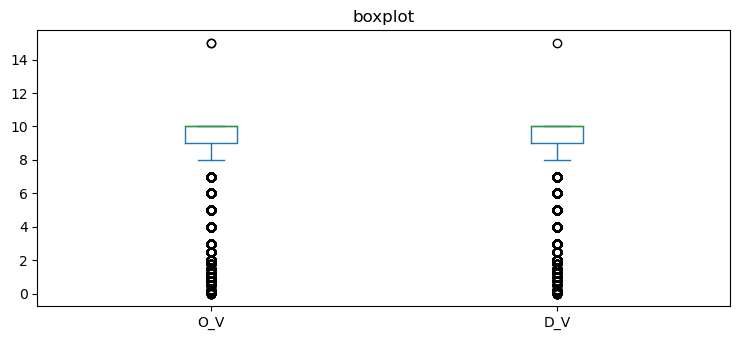

In [123]:
ax = df[['O_V','D_V']].plot(kind='box', title='boxplot')
plt.show()

In [124]:
##  Splitting the dataframe to train and test

test = df.loc[df['Year'] == 2005]
train = df.loc[df['Year'] == 2004]

test = test.reset_index(drop=True)

In [125]:
test.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
0,DEN_XNA_62349,2005,1,1126512960000000000,1126526160000000000,100,DEN,XNA,616,3017,53922,5379,5431,5382,1269,1319,1272,1126512000000000000,1126522800000000000,87.0,14.0,6.0,6.0,0.0,0.0,24.49,10.0,0.0,0,350,350,350,120,160,80,350,88.0,58.0,36.0,11.0,210.0,0.0,28.67,8.0,0.0,0,350,350,350,350,350,65,350
1,RIC_EWR_87213,2005,1,1131955200000000000,1131959700000000000,75,RIC,EWR,278,13740,14734,164,163,167,25,30,28,1131955200000000000,1131958800000000000,75.0,54.0,48.0,4.0,30.0,0.0,30.08,10.0,0.0,0,350,350,150,350,350,350,350,66.0,26.0,22.0,13.0,340.0,0.0,30.23,10.0,0.0,0,350,350,350,350,350,250,350


In [126]:
test.tail(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
6564,SLC_COD_68517,2005,3,1127292600000000000,1127297580000000000,83,SLC,COD,298,24127,24045,4221,4227,4224,0,0,0,1127289600000000000,1127296800000000000,62.0,54.0,75.0,5.0,80.0,0.0,25.77,10.0,0.01,0,110,200,350,75,350,45,350,61.0,32.0,34.0,9.0,360.0,0.0,30.08,10.0,0.0,0,46,350,70,350,350,28,350
6565,MCI_ABQ_65005,2005,2,1121751300000000000,1121751300000000000,120,MCI,ABQ,718,3947,23050,1005,1025,1008,5305,5314,5308,1121749200000000000,1121749200000000000,76.0,69.0,79.0,3.0,220.0,0.0,28.96,10.0,0.00,0,150,350,180,120,350,350,350,92.0,50.0,24.0,3.0,0.0,0.0,24.75,10.0,0.0,0,350,350,350,120,350,70,350


In [127]:
test.shape,train.shape

((6566, 53), (7861, 53))

In [128]:
train['delaystatus'] = actarr['delaystatus']
train.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1,delaystatus
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,BOS_CLE_29089,2004,1,1095656400000000000,1095663240000000000,114,BOS,CLE,563,14739,14820,19,30,180,802,805,805,1095656400000000000,1095660000000000000,63.0,40.0,43.0,6.0,340.0,0.0,30.28,10.0,0.00,1,350,350,350,350,350,350,350,68.000000,42.000000,39.000000,8.0,160.0,0.0,29.500000,10.0,0.000000,0,350,350,350,350,350,250,350,0
1,CLE_ATL_44346,2004,5,1100857200000000000,1100864040000000000,114,CLE,ATL,554,14820,13874,802,805,805,971,1026,974,1100854800000000000,1100862000000000000,53.0,50.0,89.0,7.0,110.0,0.0,29.21,6.0,0.01,0,350,350,22,350,350,350,350,67.530663,50.915818,60.430915,5.0,150.0,0.0,29.154289,3.0,0.007376,0,40,350,100,350,350,25,350,1


In [129]:
test.head(2)

,FlightNumber,Year,DOW,utc_dep,utc_arr,STT,Origin,Destination,Distance,O_ws_id,D_ws_id,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,dep_roundoff,arr_roundoff,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
0,DEN_XNA_62349,2005,1,1126512960000000000,1126526160000000000,100,DEN,XNA,616,3017,53922,5379,5431,5382,1269,1319,1272,1126512000000000000,1126522800000000000,87.0,14.0,6.0,6.0,0.0,0.0,24.49,10.0,0.0,0,350,350,350,120,160,80,350,88.0,58.0,36.0,11.0,210.0,0.0,28.67,8.0,0.0,0,350,350,350,350,350,65,350
1,RIC_EWR_87213,2005,1,1131955200000000000,1131959700000000000,75,RIC,EWR,278,13740,14734,164,163,167,25,30,28,1131955200000000000,1131958800000000000,75.0,54.0,48.0,4.0,30.0,0.0,30.08,10.0,0.0,0,350,350,150,350,350,350,350,66.0,26.0,22.0,13.0,340.0,0.0,30.23,10.0,0.0,0,350,350,350,350,350,250,350


  ['Year','FlightNumber','utc_dep','utc_arr','Origin','Destination','O_ws_id','D_ws_id','dep_roundoff','arr_roundoff']
  
   Above columns doesnot carry any usable information for the model creation, so we can drop these columns

In [130]:
train = train.drop(['Year','FlightNumber','utc_dep',"utc_arr","Origin","Destination",
                    "O_ws_id","D_ws_id","dep_roundoff","arr_roundoff"],axis = 1)

test = test.drop(['Year','FlightNumber','utc_dep',"utc_arr","Origin","Destination",
                    "O_ws_id","D_ws_id","dep_roundoff","arr_roundoff"],axis = 1)

In [131]:
train = train.reset_index(drop=True)

In [132]:
train.head()

,DOW,STT,Distance,O_gh,O_sh,O_bh,D_gh,D_sh,D_bh,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1,delaystatus
0,1,114,563,19,30,180,802,805,805,63.0,40.0,43.0,6.0,340.0,0.0,30.28,10.0,0.00,1,350,350,350,350,350,350,350,68.000000,42.000000,39.000000,8.0,160.0,0.0,29.500000,10.0,0.000000,0,350,350,350,350,350,250,350,0
1,5,114,554,802,805,805,971,1026,974,53.0,50.0,89.0,7.0,110.0,0.0,29.21,6.0,0.01,0,350,350,22,350,350,350,350,67.530663,50.915818,60.430915,5.0,150.0,0.0,29.154289,3.0,0.007376,0,40,350,100,350,350,25,350,1
2,2,62,226,49,55,52,2127,2180,2091,69.0,61.0,76.0,7.0,220.0,0.0,29.82,7.0,0.00,1,350,350,350,350,350,350,350,92.000000,27.000000,10.000000,5.0,190.0,0.0,27.560000,10.0,0.000000,1,350,350,350,350,350,350,350,0
3,2,93,508,721,769,724,8,11,40,90.0,66.0,45.0,0.0,0.0,0.0,29.26,10.0,0.00,0,350,350,350,350,350,45,350,91.000000,76.000000,61.000000,9.0,270.0,0.0,30.050000,10.0,0.000000,0,250,350,350,350,350,350,350,0
4,4,76,334,871,838,874,655,674,658,68.0,58.0,70.0,10.0,130.0,0.0,29.02,10.0,0.00,0,250,350,350,220,350,65,350,75.000000,55.000000,50.000000,5.0,210.0,0.0,29.500000,10.0,0.000000,0,350,350,350,250,350,80,350,0


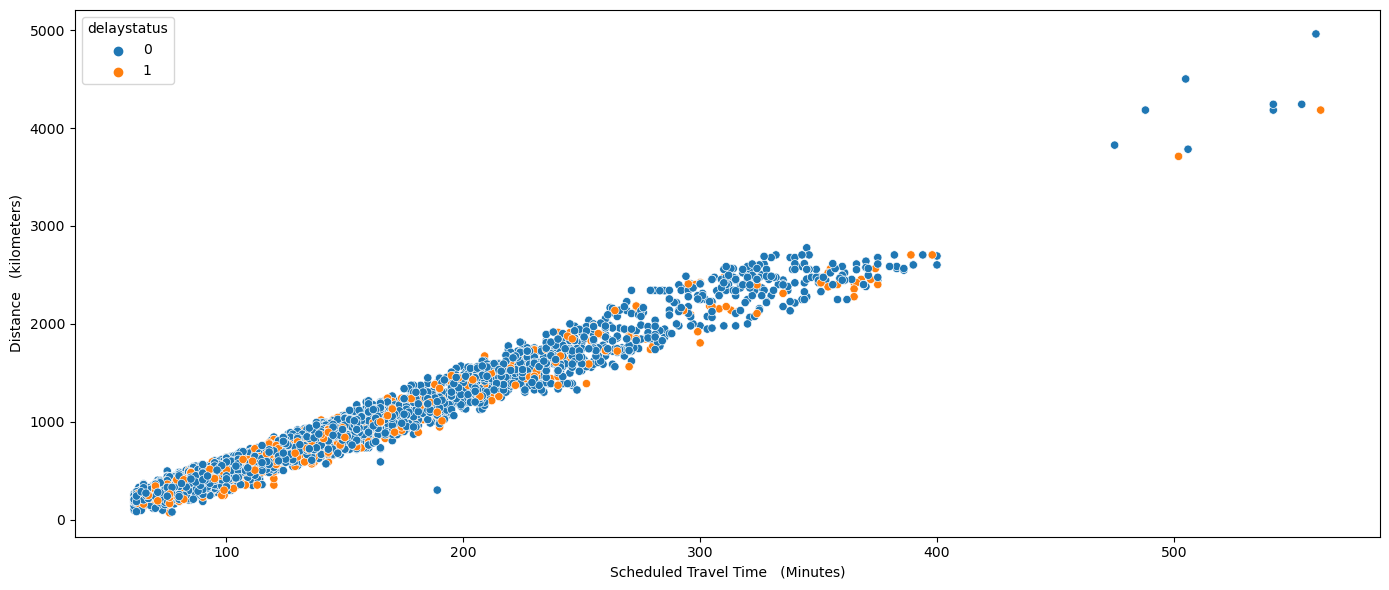

In [133]:
plt.figure(figsize=(14, 6), dpi=100)
plt.xlabel('Scheduled Travel Time   (Minutes)')
plt.ylabel('Distance   (kilometers)')
sns.scatterplot(data=train, x="STT", y="Distance", hue="delaystatus")
plt.show()



##### * There is a linear realtionship between Scheduled travel time and Distance travelled,
##### * Delaystatus is not biased on distance or scheduled travel time

#  

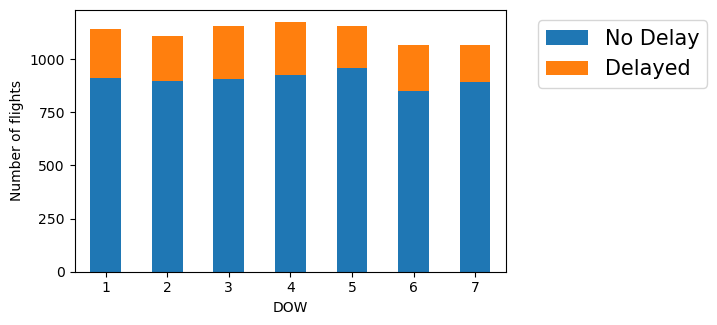

In [134]:
pd.crosstab(train['DOW'],train['delaystatus']).plot.bar(stacked=True)
plt.ylabel('Number of flights')
plt.rcParams.update({'font.size': 15})
ax = plt.subplot(111)
ax.legend(['No Delay','Delayed'],bbox_to_anchor=(1.05, 1))
plt.xticks(rotation = 0)
plt.show()

##### *  By observing above barplot we can conclude that day of week doesnot have a major impact on the delaystatus 
##### *  Day Of Week (DOW) doesnot create Bias on the target column and we can drop that column.


##  

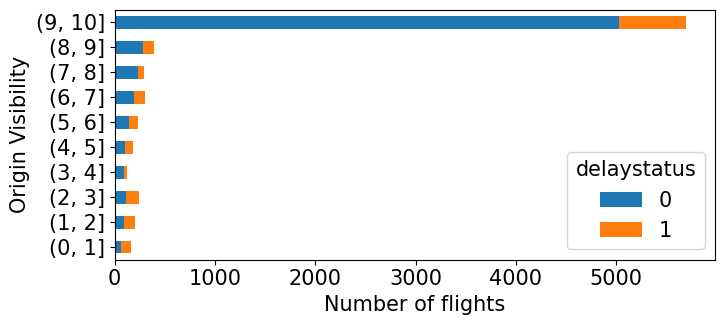

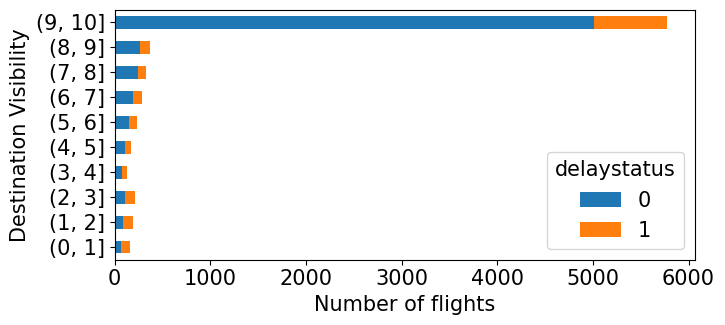

In [135]:
V_bins = [0,1,2,3,4,5,6,7,8,9,10]
O_bins = pd.cut(train['O_V'], V_bins)
D_bins = pd.cut(train['D_V'], V_bins)
pd.crosstab(O_bins,train['delaystatus']).plot.barh(stacked=True)
plt.xlabel('Number of flights')
plt.ylabel('Origin Visibility')
pd.crosstab(D_bins,train['delaystatus']).plot.barh(stacked=True)
plt.xlabel('Number of flights')
plt.ylabel('Destination Visibility')
plt.show()

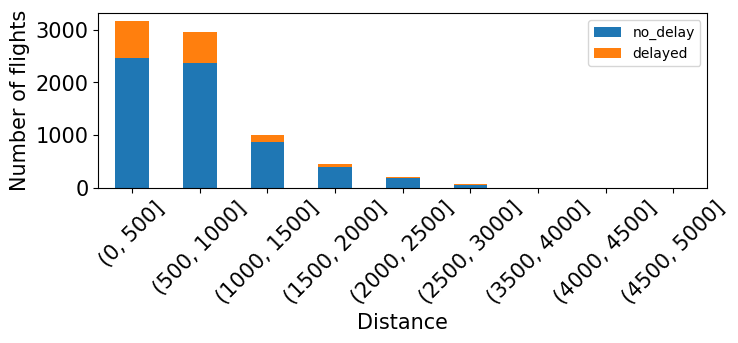

In [136]:
bins = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000]
bins = pd.cut(train['Distance'], bins)

pd.crosstab(bins,train['delaystatus']).plot.bar(stacked=True)
plt.ylabel('Number of flights')
plt.rcParams.update({'font.size': 10})
ax = plt.subplot(111)
ax.legend(['no_delay','delayed'],bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

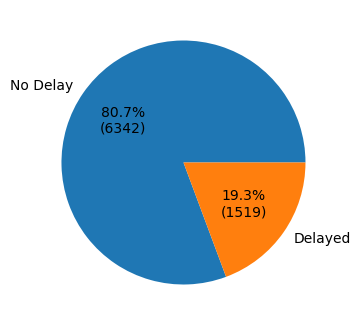

In [137]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = actarr['delaystatus'].value_counts()
plt.pie(s,labels = ["No Delay", "Delayed"], autopct=autopct_format(s))
plt.rcParams.update({'font.size': 15})
plt.show()

####  By observing the pie chart we can conclude that the dataset is Biased towards the No Delay status (0)

* majority class - No Delay (80.7%) -- 0
* minority class - Delayed (19.3%)  -- 1


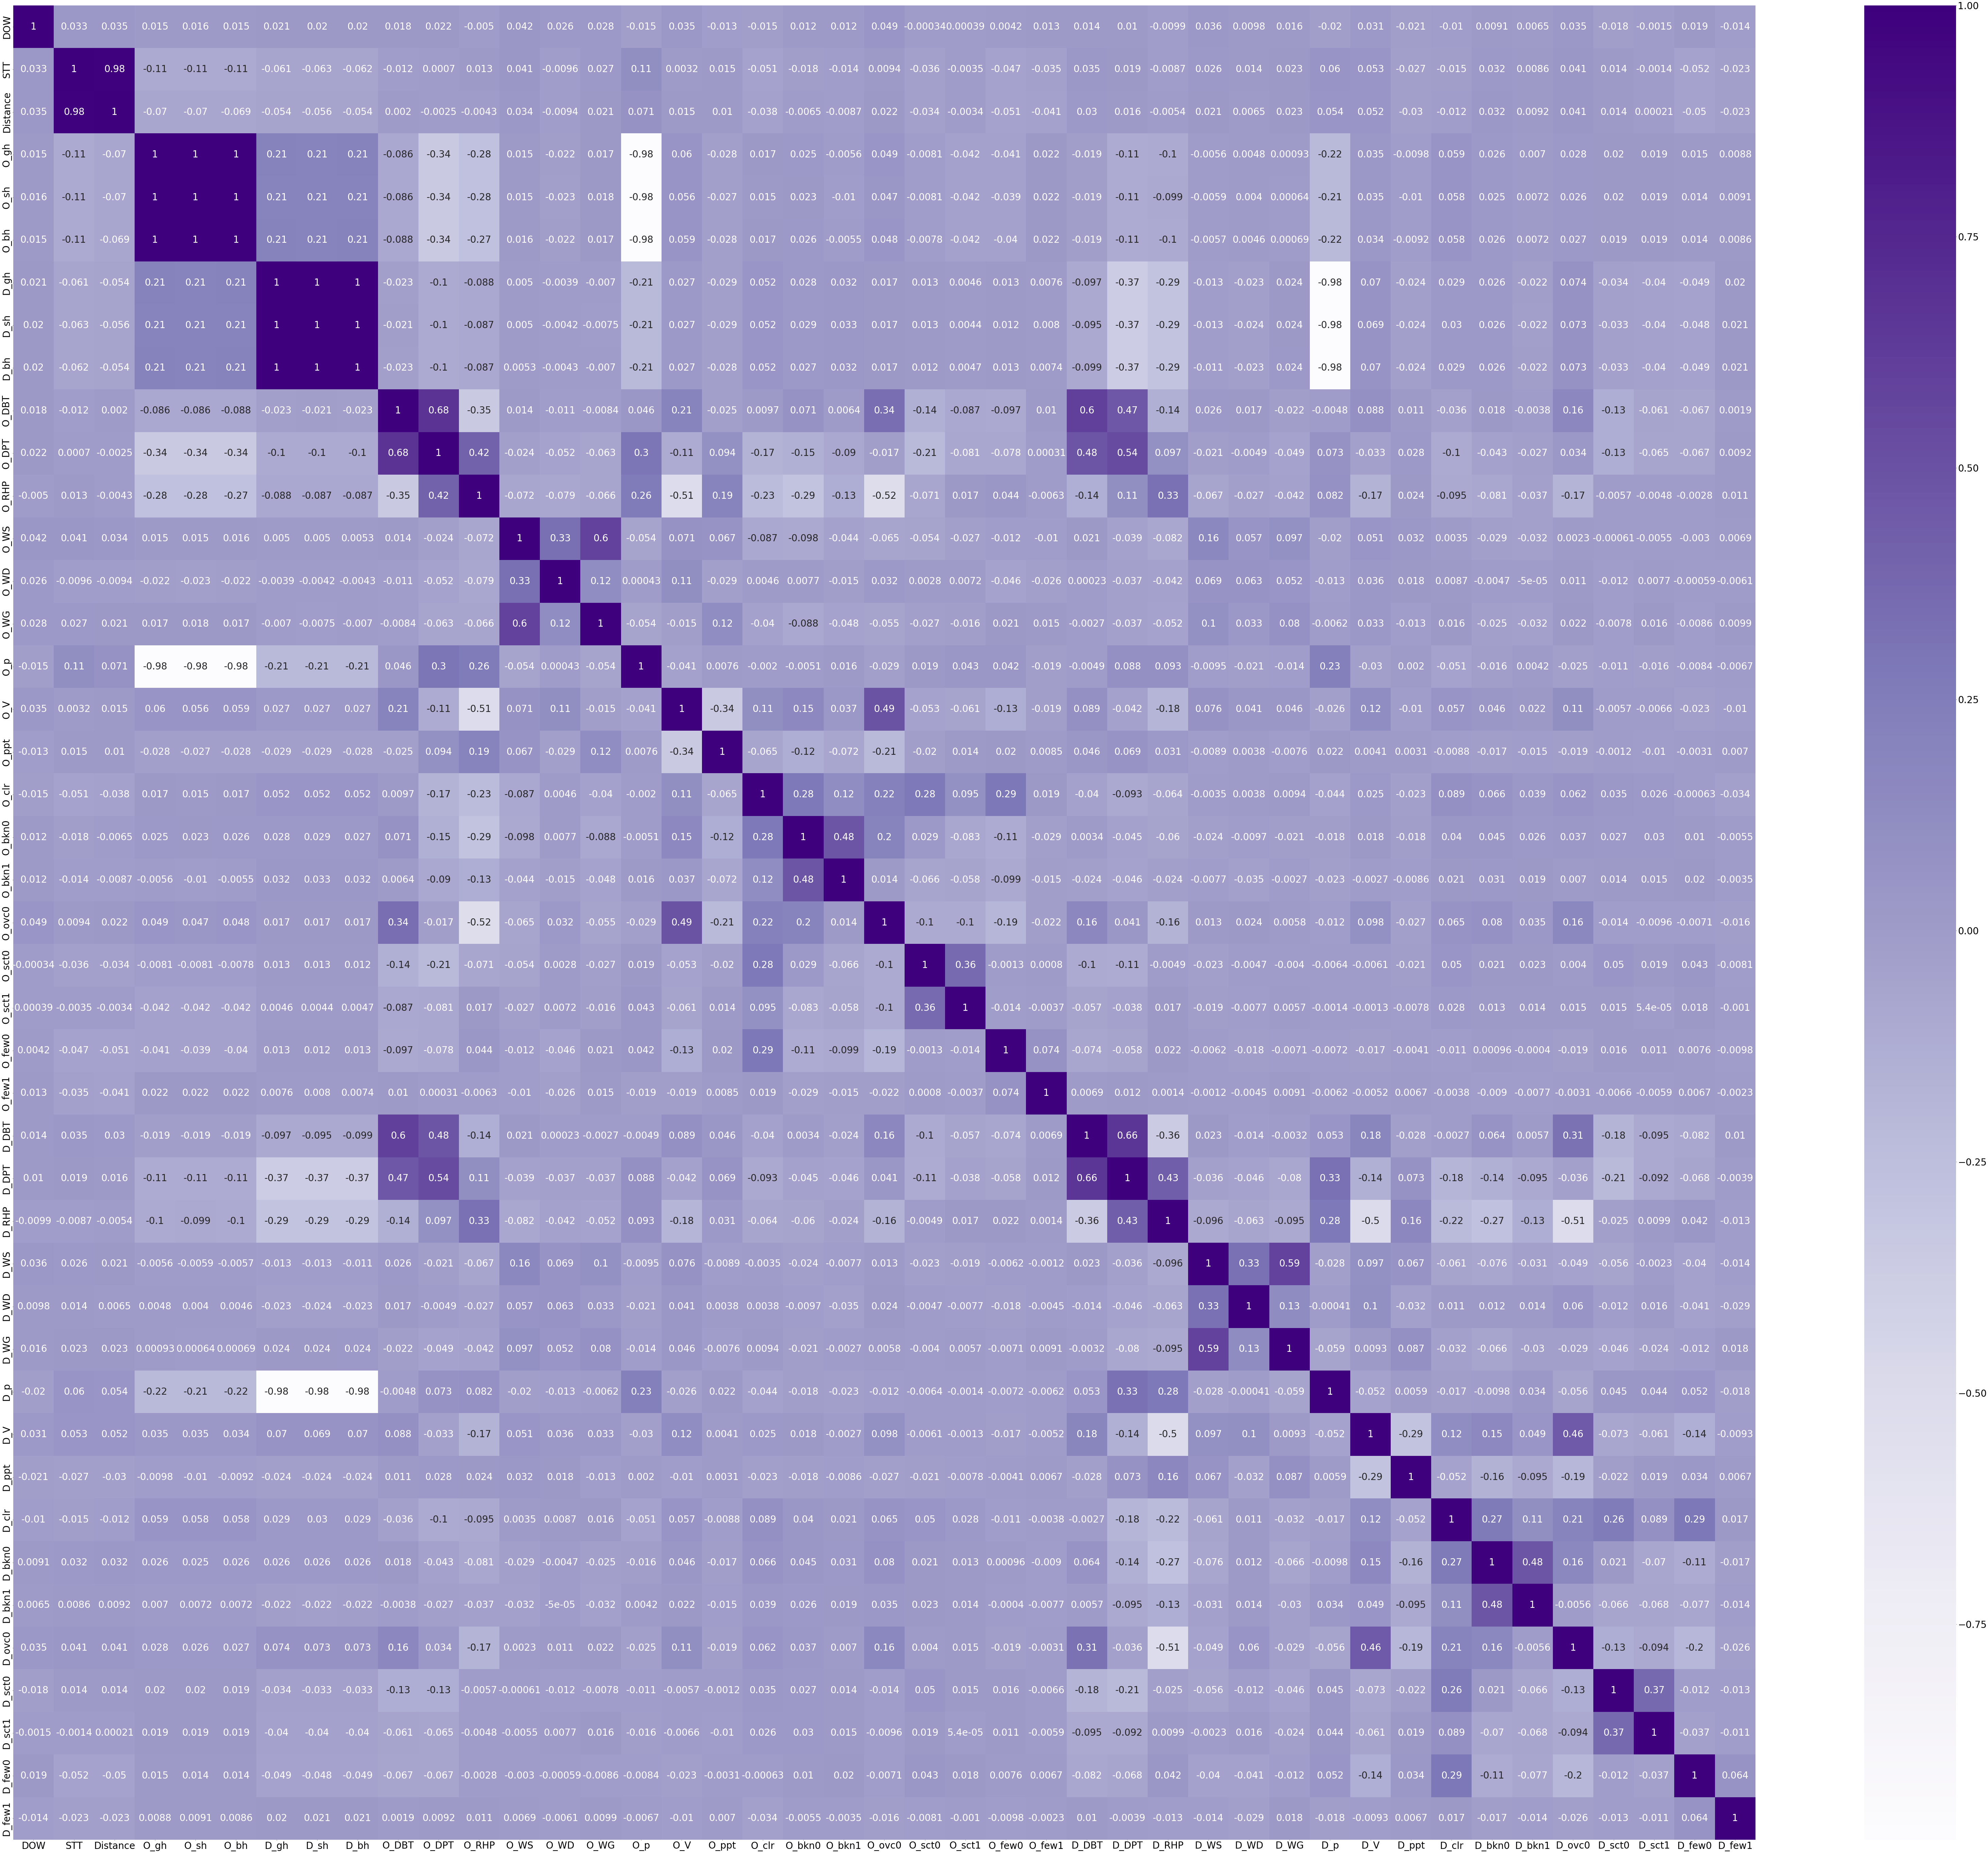

In [138]:
plt.rcParams.update({'font.size': 40})
target = 'delaystatus'
fig, ax = plt.subplots(figsize=(130, 110), dpi=50)
corr = pd.concat([train.drop(target,axis=1), train[target]],axis=1).corr()
ax = sns.heatmap(corr, annot=True, cmap='Purples')
plt.show()


 since there is high mutual correlation between ground height,station height and barometer height
 we can drop those columns

 we can see the corelation between distance and travel time, so we can drop any one of the column

In [139]:
train.drop(['STT','O_gh','O_sh','O_bh','D_gh','D_sh','D_bh','DOW'],axis = 1, inplace = True)

In [140]:
test.drop(['STT','O_gh','O_sh','O_bh','D_gh','D_sh','D_bh','DOW'],axis = 1, inplace = True)

## FEATURE SCALING

For the given Dataset there are outliers in some features, By doing any type of operations such as capping or imputations it will affect the performance of the model.

since we have outliers, using standardscalar is the best stratagy to improve the models performance rather than using Normalising.

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import warnings

In [142]:
X = train.drop('delaystatus', axis=1).copy()
Y = train['delaystatus'].copy()
Q = test.copy()

In [143]:
Y=Y.astype('int')

In [144]:
stdscale = StandardScaler()
  
# standardization for train
scaled_train = stdscale.fit_transform(X) 
scaled_train = pd.DataFrame(scaled_train, columns=X.columns,index=X.index)
scaled_train.head()

# standardization for test
scaled_test = stdscale.fit_transform(Q) 
scaled_test = pd.DataFrame(scaled_test, columns=Q.columns,index=Q.index)
scaled_test.head()

,Distance,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
0,-0.285030,1.097128,-1.885911,-2.405426,-0.486048,-1.474515,-0.396137,-3.932438,0.494388,-0.164612,-0.395208,0.727763,0.310987,0.548087,-1.106179,-3.515019,-1.115152,0.04749,1.132654,0.502805,-1.003287,0.538787,0.344686,-0.396244,-0.414619,-0.407709,-0.154696,-0.417094,0.676971,0.291995,0.512616,0.680267,0.237161,-1.212715,0.027829
1,-0.924219,0.467469,0.279116,-0.507832,-0.895774,-1.210166,-0.396137,0.780599,0.494388,-0.164612,-0.395208,0.727763,0.310987,-1.080008,0.695770,0.243808,0.786967,0.04749,-0.034792,-1.235868,-1.645093,0.960253,1.503118,-0.396244,0.922192,0.470077,-0.154696,-0.417094,0.676971,0.291995,0.512616,0.680267,0.237161,0.096728,0.027829
2,-0.997972,0.414997,-0.208015,-1.050002,-0.076322,0.464049,-0.396137,0.595113,0.494388,-0.164612,2.530312,0.727763,0.310987,0.548087,0.695770,0.243808,0.786967,0.04749,0.442800,0.665806,0.188637,-0.514878,-1.526626,-0.396244,0.039554,0.470077,-0.154696,-0.417094,0.676971,0.291995,0.512616,0.680267,0.237161,-1.460448,0.027829
3,-0.476031,-0.686907,-1.074026,-0.869278,0.128540,-1.386399,-0.396137,0.949223,0.494388,-0.164612,2.530312,0.727763,0.310987,0.548087,0.695770,0.243808,0.786967,0.04749,-1.839026,-1.833538,-0.361482,0.328054,0.255576,-0.396244,0.219509,0.470077,-0.154696,-0.417094,-1.328761,0.291995,-0.329247,0.680267,0.237161,0.804535,0.027829
4,-1.156823,-0.581964,0.116739,1.254220,-1.100637,0.375932,-0.396137,0.536094,-2.338959,-0.164612,-0.395208,0.727763,0.310987,-2.244095,0.695770,0.243808,0.786967,0.04749,-0.247054,0.448472,1.197188,-0.936344,-0.368194,-0.396244,0.382326,-3.150792,-0.154696,-0.417094,0.676971,0.291995,-2.358137,0.680267,0.237161,0.804535,0.027829


In [145]:
scaled_train.head()

,Distance,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
0,-0.345896,-0.313484,-0.825816,-0.940410,-0.490295,1.604724,-0.385356,0.907913,0.498199,-0.171140,2.607415,0.726304,0.31232,0.586264,0.721446,0.247148,0.746334,0.049392,-0.017277,-0.711089,-1.102287,-0.065364,-0.037471,-0.378183,0.282796,0.484115,-0.142950,-0.370093,0.716127,0.302772,0.560707,0.706989,0.241029,0.067696,0.046791
1,-0.363118,-0.970838,-0.166634,1.219511,-0.278143,-0.473989,-0.385356,0.021997,-1.131985,-0.046677,-0.383522,0.726304,0.31232,-1.949471,0.721446,0.247148,0.746334,0.049392,-0.048281,-0.120130,-0.099496,-0.705139,-0.128723,-0.378183,-0.000305,-2.444092,-0.018225,-0.370093,-1.677599,0.302772,-1.389344,0.706989,0.241029,-1.519077,0.046791
2,-0.990754,0.080928,0.558465,0.609099,-0.278143,0.520178,-0.385356,0.527052,-0.724439,-0.171140,2.607415,0.726304,0.31232,0.586264,0.721446,0.247148,0.746334,0.049392,1.568136,-1.705320,-2.459250,-0.705139,0.236286,-0.378183,-1.305862,0.484115,-0.142950,2.702027,0.716127,0.302772,0.560707,0.706989,0.241029,0.772929,0.046791
3,-0.451140,1.461372,0.888056,-0.846501,-1.763204,-1.468156,-0.385356,0.063395,0.498199,-0.171140,-0.383522,0.726304,0.31232,0.586264,0.721446,0.247148,-1.418601,0.049392,1.502077,1.542501,-0.072868,0.147895,0.966304,-0.378183,0.733189,0.484115,-0.142950,-0.370093,-0.056043,0.302772,0.560707,0.706989,0.241029,0.772929,0.046791
4,-0.784093,0.015193,0.360711,0.327370,0.358312,-0.293231,-0.385356,-0.135315,0.498199,-0.171140,-0.383522,-0.032063,0.31232,0.586264,-0.253597,0.247148,-1.276638,0.049392,0.445135,0.150578,-0.587577,-0.705139,0.418791,-0.378183,0.282796,0.484115,-0.142950,-0.370093,0.716127,0.302772,0.560707,-0.066349,0.241029,-1.131199,0.046791


###  FEATURE SELECTION

We are using the Mutual Info Classifier to find out the important features in datasets,
and SelectKBest to select only the most important(15) features

In [146]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [147]:
mutual_info = mutual_info_classif(scaled_train,Y)

In [148]:
mi = pd.Series(list(mutual_info))
mi.index = scaled_train.columns
mi.sort_values(ascending = False)

O_RHP       0.063827
O_V         0.055259
O_ovc0      0.050920
O_ppt       0.041448
D_RHP       0.040714
O_bkn0      0.033170
D_V         0.030884
D_bkn0      0.020087
D_ovc0      0.019765
Distance    0.019752
D_ppt       0.018686
O_few0      0.018293
O_p         0.018154
O_sct0      0.017144
O_DPT       0.015704
D_sct0      0.014948
O_DBT       0.014212
O_clr       0.013557
D_WS        0.011936
D_few0      0.008692
D_p         0.006810
D_DBT       0.006503
O_bkn1      0.006495
D_WD        0.006371
D_bkn1      0.005916
D_DPT       0.005306
O_sct1      0.005252
O_WG        0.004884
O_WD        0.004748
D_clr       0.002260
D_sct1      0.001847
O_WS        0.001450
D_WG        0.000458
O_few1      0.000000
D_few1      0.000000
dtype: float64

<AxesSubplot:>

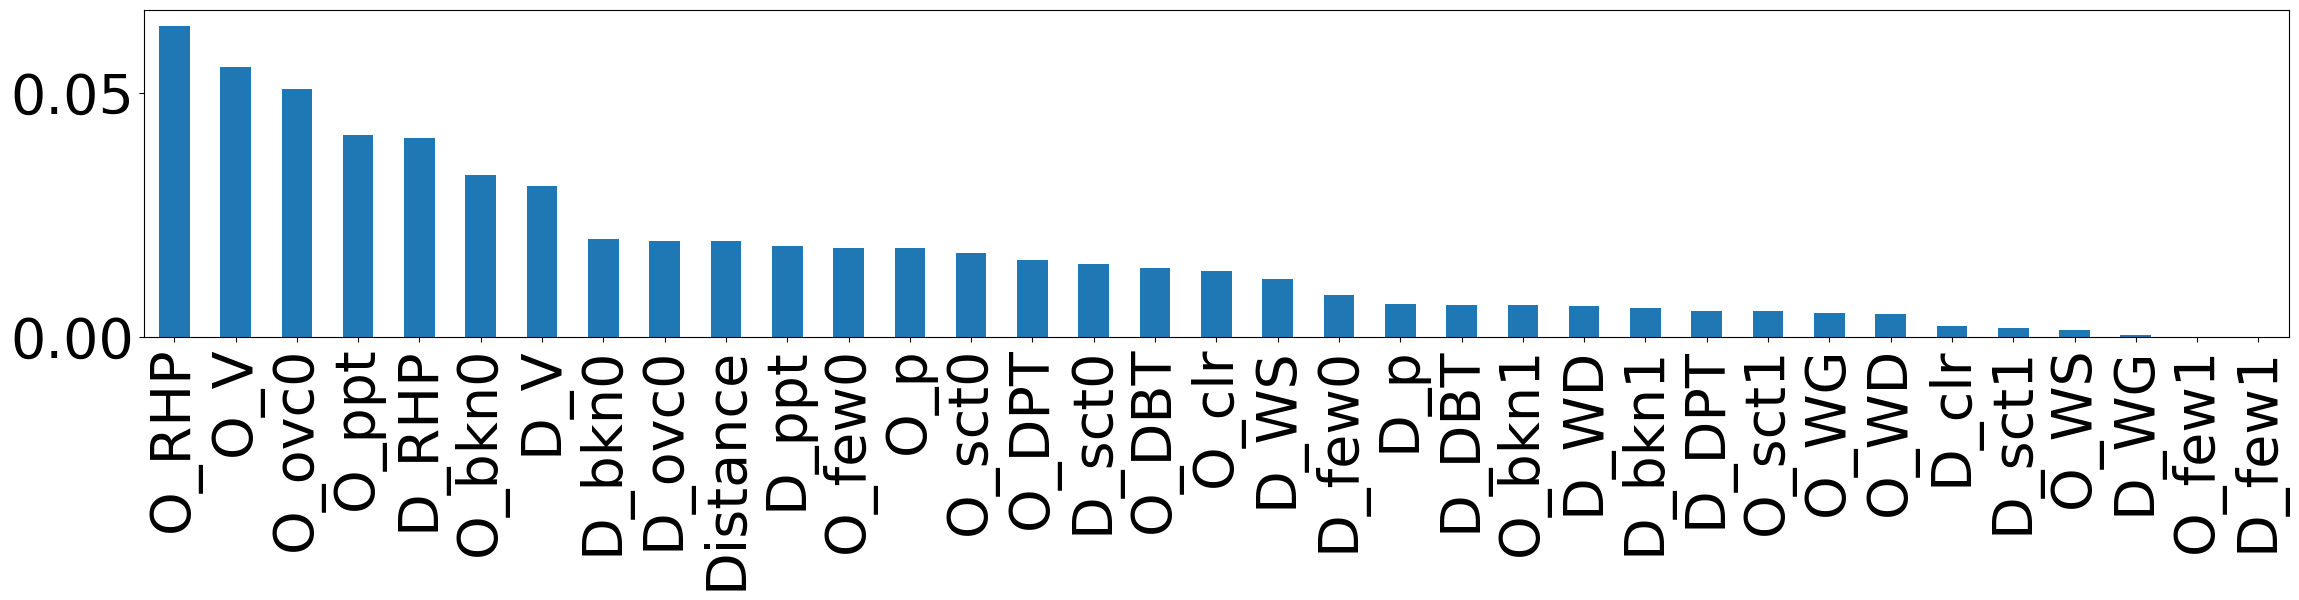

In [149]:
mi.sort_values(ascending = False).plot.bar(figsize =(24,7) )

In [150]:
tt_cols = SelectKBest(mutual_info_classif, k=15)
tr = tt_cols.fit_transform(scaled_train,Y)

In [151]:
cols = tt_cols.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
selected_columns

['Distance',
 'O_DBT',
 'O_RHP',
 'O_p',
 'O_V',
 'O_ppt',
 'O_bkn0',
 'O_ovc0',
 'D_DPT',
 'D_RHP',
 'D_V',
 'D_ppt',
 'D_bkn0',
 'D_ovc0',
 'D_few0']

In [152]:
scaled_test.head()

,Distance,O_DBT,O_DPT,O_RHP,O_WS,O_WD,O_WG,O_p,O_V,O_ppt,O_clr,O_bkn0,O_bkn1,O_ovc0,O_sct0,O_sct1,O_few0,O_few1,D_DBT,D_DPT,D_RHP,D_WS,D_WD,D_WG,D_p,D_V,D_ppt,D_clr,D_bkn0,D_bkn1,D_ovc0,D_sct0,D_sct1,D_few0,D_few1
0,-0.285030,1.097128,-1.885911,-2.405426,-0.486048,-1.474515,-0.396137,-3.932438,0.494388,-0.164612,-0.395208,0.727763,0.310987,0.548087,-1.106179,-3.515019,-1.115152,0.04749,1.132654,0.502805,-1.003287,0.538787,0.344686,-0.396244,-0.414619,-0.407709,-0.154696,-0.417094,0.676971,0.291995,0.512616,0.680267,0.237161,-1.212715,0.027829
1,-0.924219,0.467469,0.279116,-0.507832,-0.895774,-1.210166,-0.396137,0.780599,0.494388,-0.164612,-0.395208,0.727763,0.310987,-1.080008,0.695770,0.243808,0.786967,0.04749,-0.034792,-1.235868,-1.645093,0.960253,1.503118,-0.396244,0.922192,0.470077,-0.154696,-0.417094,0.676971,0.291995,0.512616,0.680267,0.237161,0.096728,0.027829
2,-0.997972,0.414997,-0.208015,-1.050002,-0.076322,0.464049,-0.396137,0.595113,0.494388,-0.164612,2.530312,0.727763,0.310987,0.548087,0.695770,0.243808,0.786967,0.04749,0.442800,0.665806,0.188637,-0.514878,-1.526626,-0.396244,0.039554,0.470077,-0.154696,-0.417094,0.676971,0.291995,0.512616,0.680267,0.237161,-1.460448,0.027829
3,-0.476031,-0.686907,-1.074026,-0.869278,0.128540,-1.386399,-0.396137,0.949223,0.494388,-0.164612,2.530312,0.727763,0.310987,0.548087,0.695770,0.243808,0.786967,0.04749,-1.839026,-1.833538,-0.361482,0.328054,0.255576,-0.396244,0.219509,0.470077,-0.154696,-0.417094,-1.328761,0.291995,-0.329247,0.680267,0.237161,0.804535,0.027829
4,-1.156823,-0.581964,0.116739,1.254220,-1.100637,0.375932,-0.396137,0.536094,-2.338959,-0.164612,-0.395208,0.727763,0.310987,-2.244095,0.695770,0.243808,0.786967,0.04749,-0.247054,0.448472,1.197188,-0.936344,-0.368194,-0.396244,0.382326,-3.150792,-0.154696,-0.417094,0.676971,0.291995,-2.358137,0.680267,0.237161,0.804535,0.027829


In [153]:
tt = scaled_test[['Distance',
 'O_DBT',
 'O_RHP',
 'O_p',
 'O_V',
 'O_ppt',
 'O_bkn0',
 'O_ovc0',
 'O_sct0',
 'O_few0',
 'D_RHP',
 'D_V',
 'D_ppt',
 'D_ovc0',
 'D_sct0']]

In [154]:
trn = pd.DataFrame(tr,columns =['Distance',
 'O_DBT',
 'O_RHP',
 'O_p',
 'O_V',
 'O_ppt',
 'O_bkn0',
 'O_ovc0',
 'O_sct0',
 'O_few0',
 'D_RHP',
 'D_V',
 'D_ppt',
 'D_ovc0',
 'D_sct0'])

## MODEL BUILDING

In [156]:
X_train, X_test, y_train, y_test = train_test_split(trn,Y, 
                          random_state=42,
                          train_size=0.80, shuffle=True,stratify =Y )

In [157]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (6288, 15)
X_test shape:  (1573, 15)
y_train shape:  (6288,)
y_test shape:  (1573,)


Since the data is imbalanced we need to perform some Oversampling or Undersampling,we have used Tomeklins to Undersample the data which eliminates the tomek pairs in majority class.

undersampling is done after the train-test split to assess the model more accurately.

In [158]:
from imblearn.under_sampling import TomekLinks

ros = TomekLinks(sampling_strategy='majority')

x_tl = X_train.copy()
y_tl = y_train.copy()
# fit predictor and target variable
for i in range (3):
    X_train, y_train = ros.fit_resample(x_tl,y_tl )

In [159]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (5992, 15)
X_test shape:  (1573, 15)
y_train shape:  (5992,)
y_test shape:  (1573,)


###  XGBoost


we have used tomeklinks as the resampling stratagy, and there is still imbalanced data left in the dataset. so XGBoost can be used to predict the outcomes more precisely than logistic regression, decision tree, and random forest without overfitting the model.

In [160]:
import xgboost as xgb

In [161]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',seed = 42)
xgb_model.fit(X_train,y_train,verbose = True, early_stopping_rounds = 10,
              eval_metric = 'aucpr', eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.48875
[1]	validation_0-aucpr:0.50439
[2]	validation_0-aucpr:0.52395
[3]	validation_0-aucpr:0.53415
[4]	validation_0-aucpr:0.52838
[5]	validation_0-aucpr:0.52563
[6]	validation_0-aucpr:0.52983
[7]	validation_0-aucpr:0.52941
[8]	validation_0-aucpr:0.52610
[9]	validation_0-aucpr:0.52905
[10]	validation_0-aucpr:0.53093
[11]	validation_0-aucpr:0.53528
[12]	validation_0-aucpr:0.53446
[13]	validation_0-aucpr:0.53165
[14]	validation_0-aucpr:0.53999
[15]	validation_0-aucpr:0.53582
[16]	validation_0-aucpr:0.53668
[17]	validation_0-aucpr:0.53655
[18]	validation_0-aucpr:0.53875
[19]	validation_0-aucpr:0.54076
[20]	validation_0-aucpr:0.53880
[21]	validation_0-aucpr:0.54019
[22]	validation_0-aucpr:0.53891
[23]	validation_0-aucpr:0.53882
[24]	validation_0-aucpr:0.53785
[25]	validation_0-aucpr:0.53837
[26]	validation_0-aucpr:0.53432
[27]	validation_0-aucpr:0.53199
[28]	validation_0-aucpr:0.53378
[29]	validation_0-aucpr:0.53338


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [162]:
pred = xgb_model.predict(X_test)

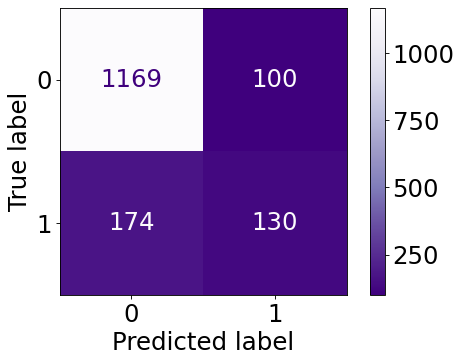

In [163]:
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, colorbar=True , cmap='Purples_r')
plt.grid(False)

In [164]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1269
           1       0.57      0.43      0.49       304

    accuracy                           0.83      1573
   macro avg       0.72      0.67      0.69      1573
weighted avg       0.81      0.83      0.82      1573



In [165]:
def metrics_calculator(y_test, pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, pred),
                                precision_score(y_test, pred, average='macro'),
                                recall_score(y_test, pred, average='macro'),
                                f1_score(y_test, pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

In [166]:
result = metrics_calculator(y_test, pred, 'XGBoost')
result

,XGBoost
Accuracy,0.825811
Precision,0.717828
Recall,0.674415
F1-score,0.690995


In [167]:
predic = xgb_model.predict(X_train)

In [168]:
result = metrics_calculator(y_train, predic, 'XGBoost')
result

,XGBoost
Accuracy,0.910714
Precision,0.900994
Recall,0.810214
F1-score,0.845148


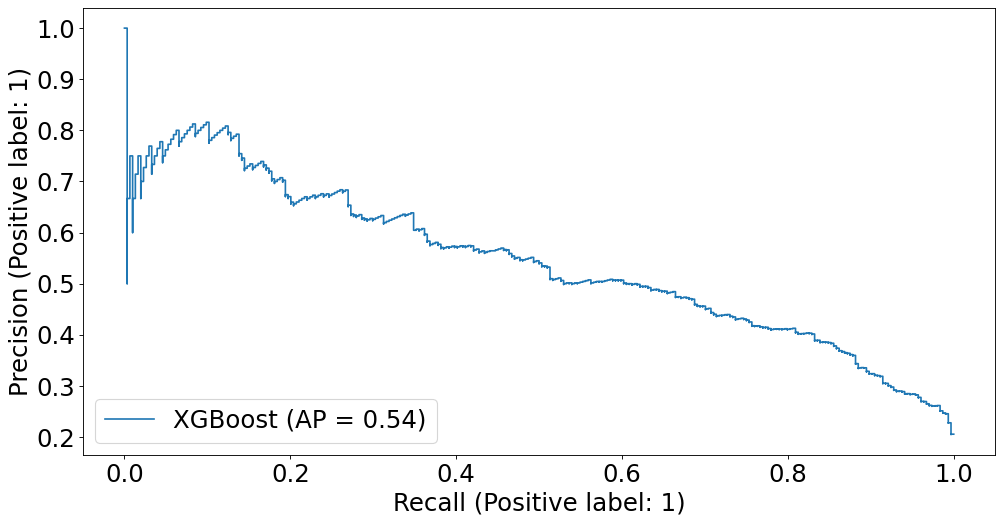

In [169]:
fig, ax = plt.subplots(figsize=(13, 7), dpi=80)
PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, name='XGBoost')
plt.show()

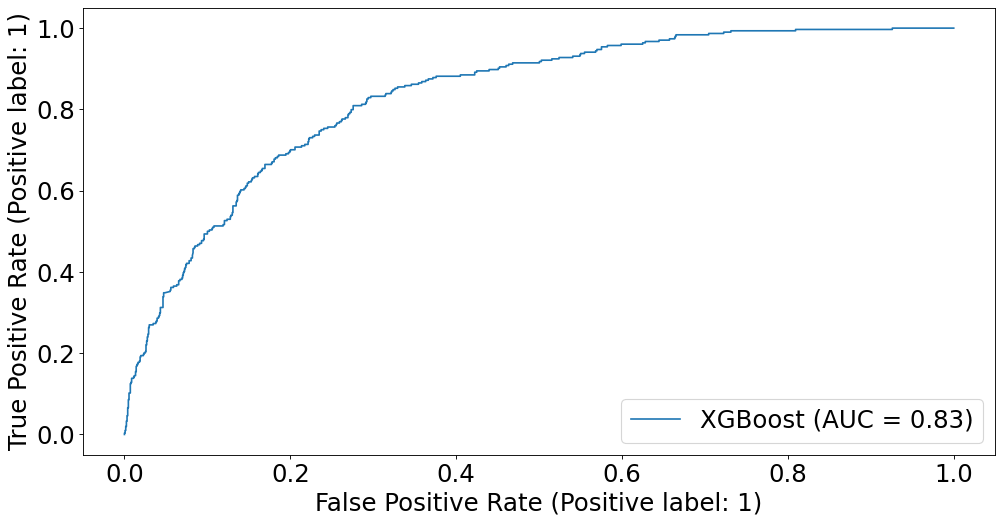

In [170]:
fig, ax = plt.subplots(figsize=(13, 7), dpi=80)
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, name='XGBoost')
plt.show()

### HYPERPARAMETER TUNING

for parametertuning stratifiedkfold crossvalidation is used to provide same ratio of target classes in every one of seven folds each.
gridsearch cv is used to predict the best combinations of the parameters provided to the algorithm, XGBClassifier is used as the estimator and the best combination is found by evaluating for 'roc_auc' since it is imbalanced data and cannot use accuracy as the evaluation metrics.

In [171]:
# Create the param grid
param_grid = { 'max_depth':[4,5,6,7],
              'learning_rate':[0.2,0.1,0.01,0.05],
              'gamma':[0,0.25,1.0,2.0],
              'reg_lamda':[0,1.0,10.0],
              'scale_pos_weight':[1,3,5]}


In [172]:
from sklearn.model_selection import GridSearchCV
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)
xgb_Grid = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                                      seed = 42,subsample = 0.9,
                                                      colsample_bytree = 0.5),
                        param_grid = param_grid, cv =cv, verbose=0, n_jobs = 10,
                       scoring = 'roc_auc')



In [173]:
xgb_Grid.fit(X_train, y_train,early_stopping_rounds = 10,
            eval_metric = 'aucpr',eval_set = [(X_test,y_test)],
            verbose = True)

[11:31:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "reg_lamda" } are not used.

[0]	validation_0-aucpr:0.44912
[1]	validation_0-aucpr:0.49647
[2]	validation_0-aucpr:0.49551
[3]	validation_0-aucpr:0.49526
[4]	validation_0-aucpr:0.50665
[5]	validation_0-aucpr:0.51409
[6]	validation_0-aucpr:0.51767
[7]	validation_0-aucpr:0.52136
[8]	validation_0-aucpr:0.52276
[9]	validation_0-aucpr:0.52422
[10]	validation_0-aucpr:0.52126
[11]	validation_0-aucpr:0.52152
[12]	validation_0-aucpr:0.52233
[13]	validation_0-aucpr:0.52665
[14]	validation_0-aucpr:0.52737
[15]	validation_0-aucpr:0.53252
[16]	validation_0-aucpr:0.53250
[17]	validation_0-aucpr:0.53417
[18]	validation_0-aucpr:0.53187
[19]	validation_0-aucpr:0.53106
[20]	validation_0-aucpr:0.52895
[21]	validation_0-aucpr:0.53192
[22]	validation_0-aucpr:0.53272
[23]	validation_0-aucpr:0.53487
[24]	validation_0-aucpr:0.53636
[25]	valida

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [174]:
print (f'Train Accuracy - : {xgb_model.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {xgb_model.score(X_test,y_test):.3f}')

Train Accuracy - : 0.911
Test Accuracy - : 0.826


In [175]:
xgb_Grid.best_params_

{'gamma': 2.0,
 'learning_rate': 0.05,
 'max_depth': 6,
 'reg_lamda': 0,
 'scale_pos_weight': 3}

In [176]:
predi = xgb_Grid.predict(X_test)

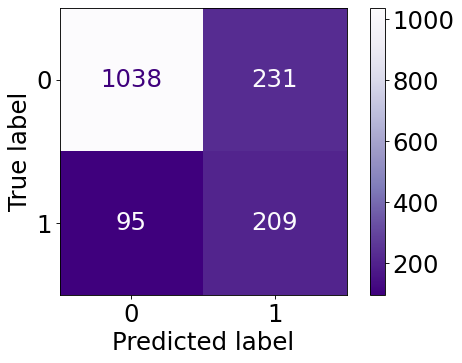

In [177]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)
ConfusionMatrixDisplay.from_estimator(xgb_Grid, X_test, y_test,ax=ax, colorbar=True, cmap='Purples_r')
plt.grid(False)

In [178]:
result = metrics_calculator(y_test, predi, 'XGBoost')
result

,XGBoost
Accuracy,0.792753
Precision,0.695576
Recall,0.752733
F1-score,0.713054


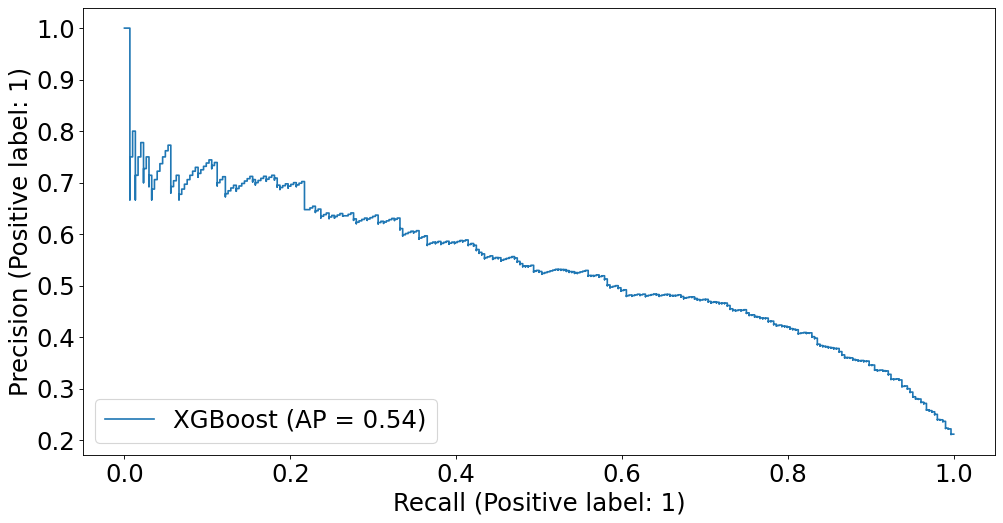

In [179]:
fig, ax = plt.subplots(figsize=(13, 7), dpi=80)
PrecisionRecallDisplay.from_estimator(xgb_Grid, X_test, y_test, ax=ax, name='XGBoost')
plt.show()

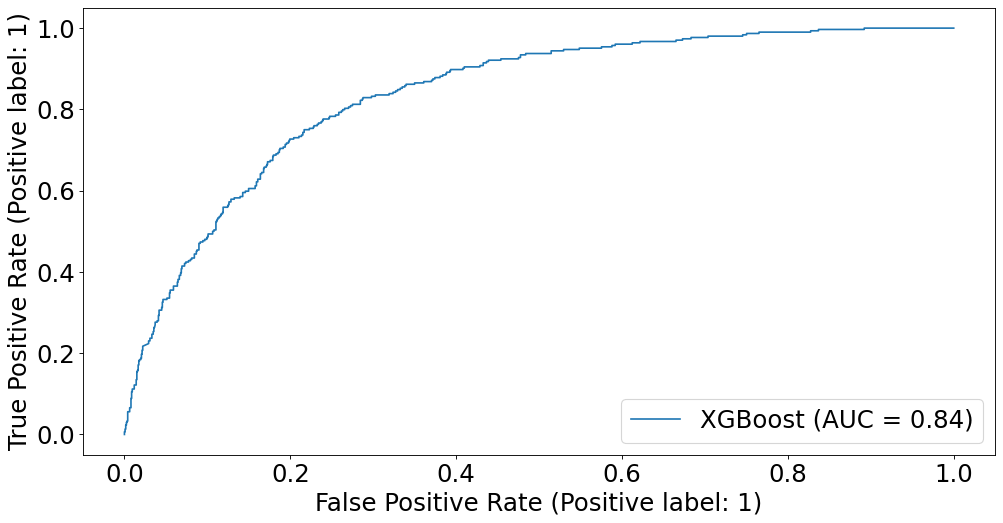

In [180]:

fig,ax = plt.subplots(figsize=(13,7), dpi=80)
RocCurveDisplay.from_estimator(xgb_Grid, X_test, y_test, ax=ax, name='XGBoost')
plt.show()

# Submission

Model is evaluated for best F1 score and the prediction results of 2005 flight travel dataset is downloaded to csv format with FlightNumber column and less than 15 mins delay is given as 2 and more than 15 mins delay, it is 1 in the flight delaystatus column. 

In [181]:
tt.head(2)

,Distance,O_DBT,O_RHP,O_p,O_V,O_ppt,O_bkn0,O_ovc0,O_sct0,O_few0,D_RHP,D_V,D_ppt,D_ovc0,D_sct0
0,-0.285030,1.097128,-2.405426,-3.932438,0.494388,-0.164612,0.727763,0.548087,-1.106179,-1.115152,-1.003287,-0.407709,-0.154696,0.512616,0.680267
1,-0.924219,0.467469,-0.507832,0.780599,0.494388,-0.164612,0.727763,-1.080008,0.695770,0.786967,-1.645093,0.470077,-0.154696,0.512616,0.680267


In [182]:
sample = pd.read_csv("samplesubmission.csv")

In [183]:
sample.head(2)

,FlightNumber,FlightDelayStatus
0,DEN_XNA_62349,2
1,RIC_EWR_87213,2


In [184]:
sample.shape,tt.shape

((6566, 2), (6566, 15))

In [185]:
delaystatus = xgb_Grid.predict(tt)
delay = pd.DataFrame(delaystatus)
sample.FlightDelayStatus = delay

In [186]:
sample['FlightDelayStatus'] = sample['FlightDelayStatus'].replace(0, 2)
sample.head(2)

,FlightNumber,FlightDelayStatus
0,DEN_XNA_62349,2
1,RIC_EWR_87213,2


In [187]:
sample.FlightDelayStatus.value_counts()

2    5022
1    1544
Name: FlightDelayStatus, dtype: int64

sample.to_csv("sub_v83.csv",index = False)

In [ ]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

### program workflow
* Loaded the datasets 
* Converted all the dataset's local time to UTC and rounded off the UTC times to hour
* Merged all the datasets to a single dataframe by using weatherstation ID and Airport ID.
* Performed feature extraction on SkyConditions and Visibility columns
* Feature engineering, Imputation, NA values and EDA.
* Feature scaling and Feature selection.
* Model building and Hyperparameter tuning.
* Downloading the prediction results

## Conclusion

After the completion of EDA, it is found that most influential factors affecting flightdelays when we consider weather are Visibility, Humidity, Precipitation and Overcast clouds. These are major factors causing most of the flight delays and downturn in economic activity.

It is advised to schdule the flights by getting more insights from weather forcasts and to keep a buffer time for the arrival timings. One strategy to reduce delays is the increased use of high-tech monitoring technology, to help airports and airlines run more efficiently by collecting more data from the weather reports.

The performance of the model can still be improved by accumulating the quality rich data and the remaining imbalance in the data can be treated by using a better combination of models with oversmapling / using both under and oversampling techniques / SMOTE-Tomeklinks combination with a much advanced model. However such a complex model would require higher computational power and effort. 